In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>.output_result { max-width:100% !important; }</style>"))

In [2]:
%run ./model_end_events_for_outages_METHODS.ipynb

In [3]:
from importlib import reload
#reload(Utilities)
#reload(clm)
# NOTE: To reload a class imported as, e.g., 
# from module import class
# One must call:
#   1. import module
#   2. reload module
#   3. from module import class

import sys, os
import re
import string
from pathlib import Path
import json
import pickle
import joblib

import pandas as pd
import numpy as np
from pandas.api.types import is_numeric_dtype, is_datetime64_dtype, is_timedelta64_dtype
from scipy import stats
import datetime
import time
from natsort import natsorted, ns, natsort_keygen
from packaging import version
import copy
from functools import reduce

import itertools

import pyodbc
#---------------------------------------------------------------------
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker
from matplotlib import dates
import matplotlib.colors as mcolors
import matplotlib.cm as cm #e.g. for cmap=cm.jet
#---------------------------------------------------------------------
sys.path.insert(0, os.path.realpath('..'))
import Utilities_config
#-----
import CommonLearningMethods as clm
#-----
from MeterPremise import MeterPremise
from EEMSP import EEMSP
#-----
from AMI_SQL import AMI_SQL
from AMINonVee_SQL import AMINonVee_SQL
from AMIEndEvents_SQL import AMIEndEvents_SQL
from AMIUsgInst_SQL import AMIUsgInst_SQL
from DOVSOutages_SQL import DOVSOutages_SQL
#-----
from GenAn import GenAn
from AMINonVee import AMINonVee
from AMIEndEvents import AMIEndEvents
from AMIEDE_DEV import AMIEDE_DEV
from MECPODf import MECPODf
from MECPOAn import MECPOAn
from MECPOCollection import MECPOCollection
from AMIUsgInst import AMIUsgInst
from DOVSOutages import DOVSOutages
from OutageModeler import OutageModeler
#---------------------------------------------------------------------
sys.path.insert(0, Utilities_config.get_sql_aids_dir())
import Utilities_sql
import TableInfos
from TableInfos import TableInfo
from SQLElement import SQLElement
from SQLElementsCollection import SQLElementsCollection
from SQLSelect import SQLSelectElement, SQLSelect
from SQLFrom import SQLFrom
from SQLWhere import SQLWhereElement, SQLWhere
from SQLJoin import SQLJoin, SQLJoinCollection
from SQLGroupBy import SQLGroupByElement, SQLGroupBy
from SQLHaving import SQLHaving
from SQLOrderBy import SQLOrderByElement, SQLOrderBy
from SQLQuery import SQLQuery
from SQLQueryGeneric import SQLQueryGeneric
#---------------------------------------------------------------------
#sys.path.insert(0, os.path.join(os.path.realpath('..'), 'Utilities'))
sys.path.insert(0, Utilities_config.get_utilities_dir())
import Utilities
import Utilities_df
from Utilities_df import DFConstructType
import Utilities_dt
import Plot_General
import Plot_Box_sns
import Plot_Hist
import Plot_Bar
import GrubbsTest
import DataFrameSubsetSlicer
from DataFrameSubsetSlicer import DataFrameSubsetSlicer as DFSlicer
from CustomJSON import CustomEncoder, CustomWriter

In [4]:
from sklearn.preprocessing import OrdinalEncoder

In [5]:
from sklearn.base import BaseEstimator
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GroupShuffleSplit, GridSearchCV, RandomizedSearchCV, cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn import preprocessing

import tensorflow as tf
from tensorflow import keras

import scipy

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# ---------------------------------------------------------------------------------------------------

In [6]:
fig_num=0
data_dir_base = r'C:\Users\s346557\Documents\LocalData\dovs_and_end_events_data'

# save_dir_model_base = r'C:\Users\s346557\Documents\LocalData\dovs_and_end_events_data\20230615\Models_00_05'
# save_dir_model_base = r'C:\Users\s346557\Documents\LocalData\dovs_and_end_events_data\20230615\Models'
save_dir_model_base = r'C:\Users\s346557\Documents\LocalData\dovs_and_end_events_data\20231201\Models'


In [7]:
save_results = False
save_model   = False

# save_dir_model = None
save_dir_model = 'All_EEMSP_agg_Top10_v3'
if save_dir_model is None:
    save_dir_model = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
save_dir_model = os.path.join(save_dir_model_base, save_dir_model)
#-----
if not os.path.exists(save_dir_model) and (save_results or save_model):
    os.makedirs(save_dir_model)

In [8]:
build_mecpo_colls = False

In [9]:
if build_mecpo_colls:
    verbose = True
    #----- Outages -------------------------------------------------------------
    # run_date_outg = '20230615'
    # event_date_ranges_outg = [
    #     ['2020-01-01', '2020-12-31'],
    #     ['2021-01-01', '2021-12-31'], 
    #     ['2022-01-01', '2022-09-30'], 
    # ]
    run_date_outg = '20231201'
    event_date_ranges_outg = [
        ['2023-04-01', '2023-09-30'], 
    ]
#     run_date_outg = '20231221'
#     event_date_ranges_outg = [
#         ['2023-04-01', '2023-11-30'], 
#     ]
    grp_by_cols_outg = ['outg_rec_nb', 'trsf_pole_nb']    
    #----- No Outages ----------------------------------------------------------
#     run_date_no_outg = '20230512'
#     event_date_ranges_no_outg = [
#         ['2022-01-01', '2022-12-31'], 
#     ]
    run_date_no_outg = '20231201'
    event_date_ranges_no_outg = [
        ['2023-04-01', '2023-09-30'], 
    ]
#     run_date_no_outg = '20231221'
#     event_date_ranges_no_outg = [
#         ['2023-04-01', '2023-11-30'], 
#     ]
    grp_by_cols_no_outg = ['trsf_pole_nb', 'no_outg_rec_nb']    
    #----- No Outages Pristine -------------------------------------------------
#     run_date_no_outg_prstn = '20230301'
#     event_date_ranges_no_outg_prstn = [
#         ['2022-01-01', '2022-12-31'], 
#     ]
    run_date_no_outg_prstn = '20231201'
    event_date_ranges_no_outg_prstn = [
        ['2023-04-01', '2023-09-30'], 
    ]
#     run_date_no_outg_prstn = '20231221'
#     event_date_ranges_no_outg_prstn = [
#         ['2023-04-01', '2023-11-30'], 
#     ]
    grp_by_cols_no_outg_prstn = ['trsf_pole_nb', 'no_outg_rec_nb']    
    #---------------------------------------------------------------------------
    normalize_by_time_interval  = True
    #-----
    include_power_down_minus_up = False
    pd_col = 'Primary Power Down'
    pu_col = 'Primary Power Up'
    pd_m_pu_col = 'Power Down Minus Up'
    #-----
    regex_to_remove_patterns    = ['.*cleared.*', '.*Test Mode.*']
    regex_to_remove_ignore_case = True
    #---------------------------------------------------------------------------
    max_total_counts = None
    # max_total_counts=150
    # max_total_counts={
    #     '01-05 Days':150, 
    #     '06-10 Days':150, 
    #     '11-15 Days':150, 
    #     '16-20 Days':150,
    #     '21-25 Days':150, 
    #     '26-30 Days':150
    # }
    how_max_total_counts='any'
    #---------------------------------------------------------------------------    
    rcpo_dfs_name_outg          = 'rcpo_df_norm_by_xfmr_nSNs'
    rcpo_dfs_name_no_outg       = 'rcpo_df_norm_by_xfmr_nSNs'
    rcpo_dfs_name_no_outg_prstn = 'rcpo_df_norm_by_xfmr_nSNs'

    mecpo_idx_for_ordering = 0
    #-------------------------
    icpo_dfs_name_outg          = 'i'+rcpo_dfs_name_outg[1:]
    icpo_dfs_name_no_outg       = 'i'+rcpo_dfs_name_no_outg[1:]
    icpo_dfs_name_no_outg_prstn = 'i'+rcpo_dfs_name_no_outg_prstn[1:]    
    #---------------------------------------------------------------------------
    freq='5D'
    days_min_max_outg_td_windows=[
        [1,6], [6,11], [11,16], [16,21], [21,26], [26,31]
    ]
    old_to_new_keys_dict = {
        'outg_td_window_1_to_6_days'  :'01-06 Days',
        'outg_td_window_6_to_11_days' :'06-11 Days',
        'outg_td_window_11_to_16_days':'11-16 Days',
        'outg_td_window_16_to_21_days':'16-21 Days',
        'outg_td_window_21_to_26_days':'21-26 Days',
        'outg_td_window_26_to_31_days':'26-31 Days'
    }

    #-------------------------
    assert(len(old_to_new_keys_dict)==len(days_min_max_outg_td_windows))
    #-------------------------
    # Sanity check
    for window_i in days_min_max_outg_td_windows:
        assert(pd.Timedelta(f'{window_i[1]}D')-pd.Timedelta(f'{window_i[0]}D')==pd.Timedelta(freq))

In [10]:
if build_mecpo_colls:
    #----------------------------------------------------------------------------------------------------
    pkl_dirs_dict_full = get_rcpo_pkl_dirs_for_build_and_combine_mecpo_colls_for_dates(
        dataset          = 'outg_full', 
        acq_run_date     = run_date_outg, 
        data_date_ranges = event_date_ranges_outg, 
        grp_by_cols      = grp_by_cols_outg, 
        data_dir_base    = data_dir_base
    )
    #-----
    pkl_dirs_dict_no_outg = get_rcpo_pkl_dirs_for_build_and_combine_mecpo_colls_for_dates(
        dataset          = 'no_outg', 
        acq_run_date     = run_date_no_outg, 
        data_date_ranges = event_date_ranges_no_outg, 
        grp_by_cols      = grp_by_cols_no_outg, 
        data_dir_base    = data_dir_base
    )
    #-----
    pkl_dirs_dict_no_outg_prstn = get_rcpo_pkl_dirs_for_build_and_combine_mecpo_colls_for_dates(
        dataset          = 'no_outg_prstn', 
        acq_run_date     = run_date_no_outg_prstn, 
        data_date_ranges = event_date_ranges_no_outg_prstn, 
        grp_by_cols      = grp_by_cols_no_outg_prstn, 
        data_dir_base    = data_dir_base
    )
    #----------------------------------------------------------------------------------------------------
    ede_data_dirs_full          = [os.path.join(Path(x).parent, 'EndEvents') for x in pkl_dirs_dict_full.values()]
    ede_data_dirs_no_outg       = [os.path.join(Path(x).parent, 'EndEvents') for x in pkl_dirs_dict_no_outg.values()]
    ede_data_dirs_no_outg_prstn = [os.path.join(Path(x).parent, 'EndEvents') for x in pkl_dirs_dict_no_outg_prstn.values()]
    #-----
    assert(all([os.path.exists(x) for x in ede_data_dirs_full]))
    assert(all([os.path.exists(x) for x in ede_data_dirs_no_outg]))
    assert(all([os.path.exists(x) for x in ede_data_dirs_no_outg_prstn]))

In [11]:
if build_mecpo_colls:
    mecpo_build_info_dict = dict()
    #-------------------------
    mecpo_build_info_dict['run_date_outg']                   = run_date_outg
    mecpo_build_info_dict['event_date_ranges_outg']          = event_date_ranges_outg
    mecpo_build_info_dict['grp_by_cols_outg']                = grp_by_cols_outg
    #-----
    mecpo_build_info_dict['run_date_no_outg']                = run_date_no_outg
    mecpo_build_info_dict['event_date_ranges_no_outg']       = event_date_ranges_no_outg
    mecpo_build_info_dict['grp_by_cols_no_outg']             = grp_by_cols_no_outg
    #-----
    mecpo_build_info_dict['run_date_no_outg_prstn']          = run_date_no_outg_prstn
    mecpo_build_info_dict['event_date_ranges_no_outg_prstn'] = event_date_ranges_no_outg_prstn
    mecpo_build_info_dict['grp_by_cols_no_outg_prstn']       = grp_by_cols_no_outg_prstn
    #-------------------------
    mecpo_build_info_dict['normalize_by_time_interval']      = normalize_by_time_interval
    #-------------------------
    mecpo_build_info_dict['include_power_down_minus_up']     = include_power_down_minus_up
    mecpo_build_info_dict['pd_col']                          = pd_col
    mecpo_build_info_dict['pu_col']                          = pu_col
    mecpo_build_info_dict['pd_m_pu_col']                     = pd_m_pu_col
    #-------------------------
    mecpo_build_info_dict['regex_to_remove_patterns']        = regex_to_remove_patterns
    mecpo_build_info_dict['regex_to_remove_ignore_case']     = regex_to_remove_ignore_case
    #-------------------------
    mecpo_build_info_dict['max_total_counts']                = max_total_counts
    mecpo_build_info_dict['how_max_total_counts']            = how_max_total_counts
    #-------------------------
    mecpo_build_info_dict['mecpo_idx_for_ordering']          = mecpo_idx_for_ordering
    #-------------------------
    mecpo_build_info_dict['rcpo_dfs_name_outg']              = rcpo_dfs_name_outg
    mecpo_build_info_dict['rcpo_dfs_name_no_outg']           = rcpo_dfs_name_no_outg
    mecpo_build_info_dict['rcpo_dfs_name_no_outg_prstn']     = rcpo_dfs_name_no_outg_prstn
    #-----
    mecpo_build_info_dict['icpo_dfs_name_outg']              = icpo_dfs_name_outg
    mecpo_build_info_dict['icpo_dfs_name_no_outg']           = icpo_dfs_name_no_outg
    mecpo_build_info_dict['icpo_dfs_name_no_outg_prstn']     = icpo_dfs_name_no_outg_prstn
    #-------------------------
    mecpo_build_info_dict['freq'] = freq
    #-------------------------
    mecpo_build_info_dict['days_min_max_outg_td_windows']    = days_min_max_outg_td_windows
    #-------------------------
    mecpo_build_info_dict['old_to_new_keys_dict']            = old_to_new_keys_dict
    #-------------------------
    mecpo_build_info_dict['pkl_dirs_dict_full']              = pkl_dirs_dict_full
    mecpo_build_info_dict['pkl_dirs_dict_no_outg']           = pkl_dirs_dict_no_outg
    mecpo_build_info_dict['pkl_dirs_dict_no_outg_prstn']     = pkl_dirs_dict_no_outg_prstn
    #-----
    mecpo_build_info_dict['ede_data_dirs_full']              = ede_data_dirs_full
    mecpo_build_info_dict['ede_data_dirs_no_outg']           = ede_data_dirs_no_outg
    mecpo_build_info_dict['ede_data_dirs_no_outg_prstn']     = ede_data_dirs_no_outg_prstn

# Build MECPOCollection objects

In [12]:
if build_mecpo_colls:
    #----------------------------------------------------------------------------------------------------
    # Build MECPOCollection objects
    #----------------------------------------------------------------------------------------------------
    #----- Outages ------------------------------------
    mecpo_coll_full = build_and_combine_mecpo_colls_for_dates(
        dataset                      = 'outg_full', 
        acq_run_date                 = run_date_outg, 
        data_date_ranges             = event_date_ranges_outg, 
        grp_by_cols                  = grp_by_cols_outg, 
        days_min_max_outg_td_windows = days_min_max_outg_td_windows, 
        old_to_new_keys_dict         = old_to_new_keys_dict, 
        coll_label                   = 'Outages (All Xfmrs)', 
        barplot_kwargs_shared        = dict(facecolor='red'), 
        normalize_by_time_interval   = normalize_by_time_interval, 
        data_dir_base                = data_dir_base
    )
    
    #----- No Outages ---------------------------------
    mecpo_coll_no_outg = build_and_combine_mecpo_colls_for_dates(
        dataset                      = 'no_outg', 
        acq_run_date                 = run_date_no_outg, 
        data_date_ranges             = event_date_ranges_no_outg, 
        grp_by_cols                  = grp_by_cols_no_outg, 
        days_min_max_outg_td_windows = days_min_max_outg_td_windows, 
        old_to_new_keys_dict         = old_to_new_keys_dict, 
        coll_label                   = 'No Outages', 
        barplot_kwargs_shared        = dict(facecolor='orange'), 
        normalize_by_time_interval   = normalize_by_time_interval, 
        data_dir_base                = data_dir_base
    )    
    
    #----- No Outages Pristine ------------------------
    mecpo_coll_no_outg_prstn = build_and_combine_mecpo_colls_for_dates(
        dataset                      = 'no_outg_prstn', 
        acq_run_date                 = run_date_no_outg_prstn, 
        data_date_ranges             = event_date_ranges_no_outg_prstn, 
        grp_by_cols                  = grp_by_cols_no_outg_prstn, 
        days_min_max_outg_td_windows = days_min_max_outg_td_windows, 
        old_to_new_keys_dict         = old_to_new_keys_dict, 
        coll_label                   = 'No Outages', 
        barplot_kwargs_shared        = dict(facecolor='orange'), 
        normalize_by_time_interval   = normalize_by_time_interval, 
        data_dir_base                = data_dir_base
    )    

In [13]:
if build_mecpo_colls:
    #****************************************************************************************************
    if verbose:
        print('Starting shapes:')
        #-----
        print('\tmecpo_coll_full')
        for an_key in mecpo_coll_full.mecpo_an_keys:
            print(f"\t\t{an_key}, '{rcpo_dfs_name_outg}' shape: {mecpo_coll_full.get_cpo_df(an_key, rcpo_dfs_name_outg).shape}")
        #-----
        print('\tmecpo_coll_no_outg')
        for an_key in mecpo_coll_no_outg.mecpo_an_keys:
            print(f"\t\t{an_key}, '{rcpo_dfs_name_no_outg}' shape: {mecpo_coll_no_outg.get_cpo_df(an_key, rcpo_dfs_name_no_outg).shape}")
        #-----
        print('\tmecpo_coll_no_outg_prstn')
        for an_key in mecpo_coll_no_outg_prstn.mecpo_an_keys:
            print(f"\t\t{an_key}, '{rcpo_dfs_name_no_outg_prstn}' shape: {mecpo_coll_no_outg_prstn.get_cpo_df(an_key, rcpo_dfs_name_no_outg_prstn).shape}")
    #****************************************************************************************************
    
    #----------------------------------------------------------------------------------------------------
    # Similarity operations
    #----------------------------------------------------------------------------------------------------
    # First, make columns equal between MECPOAn objects within each MECPOCollection
    mecpo_coll_full.make_cpo_columns_equal(drop_empty_cpo_dfs=True)
    mecpo_coll_no_outg.make_cpo_columns_equal(drop_empty_cpo_dfs=True)
    mecpo_coll_no_outg_prstn.make_cpo_columns_equal(drop_empty_cpo_dfs=True)

    #-------------------------
    # Now, make columns equal between the MECPOCollections
    MECPOCollection.make_cpo_columns_equal_between_mecpo_colls(
        mecpo_colls = [
            mecpo_coll_full, 
            mecpo_coll_no_outg, 
            mecpo_coll_no_outg_prstn
        ], 
        drop_empty_cpo_dfs=True
    )

    #-------------------------
    # If not all same cpo_df names are used between collections, then one should call 
    #   MECPOCollection.make_mixed_cpo_columns_equal_between_mecpo_colls.
    if not(rcpo_dfs_name_outg==rcpo_dfs_name_no_outg==rcpo_dfs_name_no_outg_prstn):
        MECPOCollection.make_mixed_cpo_columns_equal_between_mecpo_colls(
            mecpo_colls_with_cpo_df_names = [
                [mecpo_coll_full,          rcpo_dfs_name_outg], 
                [mecpo_coll_no_outg,       rcpo_dfs_name_no_outg], 
                [mecpo_coll_no_outg_prstn, rcpo_dfs_name_no_outg_prstn]
            ], 
            segregate_by_mecpo_an_keys=False
        )
    #-------------------------
    if not(icpo_dfs_name_outg==icpo_dfs_name_no_outg==icpo_dfs_name_no_outg_prstn):
        MECPOCollection.make_mixed_cpo_columns_equal_between_mecpo_colls(
            mecpo_colls_with_cpo_df_names = [
                [mecpo_coll_full,          icpo_dfs_name_outg], 
                [mecpo_coll_no_outg,       icpo_dfs_name_no_outg], 
                [mecpo_coll_no_outg_prstn, icpo_dfs_name_no_outg_prstn]
            ], 
            segregate_by_mecpo_an_keys=False
        )
        
    #****************************************************************************************************
    if verbose:
        print('\n\nAfter making columns equal amongst collections:')
        #-----
        print('\tmecpo_coll_full')
        for an_key in mecpo_coll_full.mecpo_an_keys:
            print(f"\t\t{an_key}, '{rcpo_dfs_name_outg}' shape: {mecpo_coll_full.get_cpo_df(an_key, rcpo_dfs_name_outg).shape}")
        #-----
        print('\tmecpo_coll_no_outg')
        for an_key in mecpo_coll_no_outg.mecpo_an_keys:
            print(f"\t\t{an_key}, '{rcpo_dfs_name_no_outg}' shape: {mecpo_coll_no_outg.get_cpo_df(an_key, rcpo_dfs_name_no_outg).shape}")
        #-----
        print('\tmecpo_coll_no_outg_prstn')
        for an_key in mecpo_coll_no_outg_prstn.mecpo_an_keys:
            print(f"\t\t{an_key}, '{rcpo_dfs_name_no_outg_prstn}' shape: {mecpo_coll_no_outg_prstn.get_cpo_df(an_key, rcpo_dfs_name_no_outg_prstn).shape}")
    #****************************************************************************************************
    
    #----------------------------------------------------------------------------------------------------
    # Remove and/or combine reasons
    #----------------------------------------------------------------------------------------------------
    #-------------------------
    # Remove all reasons containing 'cleared'
    mecpo_coll_full.remove_reasons_from_all_rcpo_dfs(
        regex_patterns_to_remove = regex_to_remove_patterns, 
        ignore_case              = regex_to_remove_ignore_case
    )
    mecpo_coll_no_outg.remove_reasons_from_all_rcpo_dfs(
        regex_patterns_to_remove = regex_to_remove_patterns, 
        ignore_case              = regex_to_remove_ignore_case
    )
    mecpo_coll_no_outg_prstn.remove_reasons_from_all_rcpo_dfs(
        regex_patterns_to_remove = regex_to_remove_patterns, 
        ignore_case              = regex_to_remove_ignore_case
    )

    #-------------------------
    # Combine reasons using the standard combine (see dflt_patterns_and_replace in MECPODf.combine_cpo_df_reasons
    #   for the list of default patterns_and_replace)
    red_to_org_cols_dicts_full = mecpo_coll_full.combine_reasons_in_all_rcpo_dfs(
        initial_strip               = True, 
        initial_punctuation_removal = True, 
        return_red_to_org_cols_dict = True
    )
    red_to_org_cols_dicts_no_outg = mecpo_coll_no_outg.combine_reasons_in_all_rcpo_dfs(
        initial_strip               = True, 
        initial_punctuation_removal = True, 
        return_red_to_org_cols_dict = True
    ) 
    red_to_org_cols_dicts_no_outg_prstn = mecpo_coll_no_outg_prstn.combine_reasons_in_all_rcpo_dfs(
        initial_strip               = True, 
        initial_punctuation_removal = True, 
        return_red_to_org_cols_dict = True
    )
    #-------------------------
    # Build power down minus power up counts
    if include_power_down_minus_up:
        mecpo_coll_full.delta_cpo_df_reasons_in_all_rcpo_dfs(
            reasons_1         = pd_col,
            reasons_2         = pu_col,
            delta_reason_name = pd_m_pu_col
        )
        mecpo_coll_no_outg.delta_cpo_df_reasons_in_all_rcpo_dfs(
            reasons_1         = pd_col,
            reasons_2         = pu_col,
            delta_reason_name = pd_m_pu_col
        )
        mecpo_coll_no_outg_prstn.delta_cpo_df_reasons_in_all_rcpo_dfs(
            reasons_1         = pd_col,
            reasons_2         = pu_col,
            delta_reason_name = pd_m_pu_col
        )
        
    #-------------------------
    # Don't want to include SNs or nSNs cols (and similar) in plotting, so remove
    mecpo_coll_full.remove_SNs_cols_from_all_cpo_dfs()
    mecpo_coll_no_outg.remove_SNs_cols_from_all_cpo_dfs()
    mecpo_coll_no_outg_prstn.remove_SNs_cols_from_all_cpo_dfs()
    
    #****************************************************************************************************
    if verbose:
        print('\n\nAfter removing and/or combining reasons:')
        #-----
        print('\tmecpo_coll_full')
        for an_key in mecpo_coll_full.mecpo_an_keys:
            print(f"\t\t{an_key}, '{rcpo_dfs_name_outg}' shape: {mecpo_coll_full.get_cpo_df(an_key, rcpo_dfs_name_outg).shape}")
        #-----
        print('\tmecpo_coll_no_outg')
        for an_key in mecpo_coll_no_outg.mecpo_an_keys:
            print(f"\t\t{an_key}, '{rcpo_dfs_name_no_outg}' shape: {mecpo_coll_no_outg.get_cpo_df(an_key, rcpo_dfs_name_no_outg).shape}")
        #-----
        print('\tmecpo_coll_no_outg_prstn')
        for an_key in mecpo_coll_no_outg_prstn.mecpo_an_keys:
            print(f"\t\t{an_key}, '{rcpo_dfs_name_no_outg_prstn}' shape: {mecpo_coll_no_outg_prstn.get_cpo_df(an_key, rcpo_dfs_name_no_outg_prstn).shape}")
    #****************************************************************************************************
    
    #----------------------------------------------------------------------------------------------------
    # Get merged DFs from collections
    #----------------------------------------------------------------------------------------------------
    merged_df_full = mecpo_coll_full.get_merged_cpo_dfs(
        cpo_df_name                         = rcpo_dfs_name_outg, 
        cpo_df_subset_by_mjr_mnr_cause_args = None, 
        max_total_counts                    = max_total_counts, 
        how_max_total_counts                = how_max_total_counts
    )
    merged_df_no_outg = mecpo_coll_no_outg.get_merged_cpo_dfs(
        cpo_df_name                         = rcpo_dfs_name_no_outg, 
        cpo_df_subset_by_mjr_mnr_cause_args = None, 
        max_total_counts                    = max_total_counts, 
        how_max_total_counts                = how_max_total_counts
    )
    merged_df_no_outg_prstn = mecpo_coll_no_outg_prstn.get_merged_cpo_dfs(
        cpo_df_name                         = rcpo_dfs_name_no_outg_prstn, 
        cpo_df_subset_by_mjr_mnr_cause_args = None, 
        max_total_counts                    = max_total_counts, 
        how_max_total_counts                = how_max_total_counts
    )

    #-------------------------
    # Make sure all SNs columns are removed
    merged_df_full          = MECPODf.remove_SNs_cols_from_rcpo_df(merged_df_full)
    merged_df_no_outg       = MECPODf.remove_SNs_cols_from_rcpo_df(merged_df_no_outg)
    merged_df_no_outg_prstn = MECPODf.remove_SNs_cols_from_rcpo_df(merged_df_no_outg_prstn)
    
    #-------------------------
    # Sort columns and make sure all columns equal for all
    merged_df_full          = merged_df_full[merged_df_full.columns.sort_values()]
    merged_df_no_outg       = merged_df_no_outg[merged_df_no_outg.columns.sort_values()]
    merged_df_no_outg_prstn = merged_df_no_outg_prstn[merged_df_no_outg_prstn.columns.sort_values()]
    #-----
    assert(all(merged_df_no_outg.columns==merged_df_full.columns))
    assert(all(merged_df_no_outg.columns==merged_df_no_outg_prstn.columns))
    
    #----------------------------------------------------------------------------------------------------
    # Build counts series
    #----------------------------------------------------------------------------------------------------
    counts_series_full          = mecpo_coll_full.get_counts_series(rcpo_dfs_name_outg, False)
    counts_series_no_outg       = mecpo_coll_no_outg.get_counts_series(rcpo_dfs_name_no_outg, False)
    counts_series_no_outg_prstn = mecpo_coll_no_outg_prstn.get_counts_series(rcpo_dfs_name_no_outg_prstn, False)

# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# SAVE OR LOAD
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [14]:
if build_mecpo_colls:
    merged_df_full.to_pickle(os.path.join(save_dir_model_base, 'merged_df_full.pkl'))
    merged_df_no_outg.to_pickle(os.path.join(save_dir_model_base, 'merged_df_no_outg.pkl'))
    merged_df_no_outg_prstn.to_pickle(os.path.join(save_dir_model_base, 'merged_df_no_outg_prstn.pkl'))
    #-------------------------
    with open(os.path.join(save_dir_model_base, 'mecpo_coll_full.pkl'), 'wb') as handle:
        pickle.dump(mecpo_coll_full, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(save_dir_model_base, 'mecpo_coll_no_outg.pkl'), 'wb') as handle:
        pickle.dump(mecpo_coll_no_outg, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(save_dir_model_base, 'mecpo_coll_no_outg_prstn.pkl'), 'wb') as handle:
        pickle.dump(mecpo_coll_no_outg_prstn, handle, protocol=pickle.HIGHEST_PROTOCOL)
    #-------------------------
    with open(os.path.join(save_dir_model_base, 'counts_series_full.pkl'), 'wb') as handle:
        pickle.dump(counts_series_full, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(save_dir_model_base, 'counts_series_no_outg.pkl'), 'wb') as handle:
        pickle.dump(counts_series_no_outg, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(save_dir_model_base, 'counts_series_no_outg_prstn.pkl'), 'wb') as handle:
        pickle.dump(counts_series_no_outg_prstn, handle, protocol=pickle.HIGHEST_PROTOCOL)     
    #-------------------------
    CustomWriter.output_dict_to_json(
        os.path.join(save_dir_model_base, 'mecpo_build_info_dict.json'), 
        mecpo_build_info_dict
    )

In [15]:
if not build_mecpo_colls:
    merged_df_full=pd.read_pickle(os.path.join(save_dir_model_base, 'merged_df_full.pkl'))
    merged_df_no_outg=pd.read_pickle(os.path.join(save_dir_model_base, 'merged_df_no_outg.pkl'))
    merged_df_no_outg_prstn=pd.read_pickle(os.path.join(save_dir_model_base, 'merged_df_no_outg_prstn.pkl'))
    #-------------------------
    # with open(os.path.join(save_dir_model_base, 'mecpo_coll_full.pkl'), 'rb') as handle:
    #     mecpo_coll_full = pickle.load(handle)
    # with open(os.path.join(save_dir_model_base, 'mecpo_coll_no_outg.pkl'), 'rb') as handle:
    #     mecpo_coll_no_outg = pickle.load(handle)
    # with open(os.path.join(save_dir_model_base, 'mecpo_coll_no_outg_prstn.pkl'), 'rb') as handle:
    #     mecpo_coll_no_outg_prstn = pickle.load(handle)
    #-------------------------
    with open(os.path.join(save_dir_model_base, 'counts_series_full.pkl'), 'rb') as handle:
        counts_series_full = pickle.load(handle)
    with open(os.path.join(save_dir_model_base, 'counts_series_no_outg.pkl'), 'rb') as handle:
        counts_series_no_outg = pickle.load(handle)
    with open(os.path.join(save_dir_model_base, 'counts_series_no_outg_prstn.pkl'), 'rb') as handle:
        counts_series_no_outg_prstn = pickle.load(handle)
    #-------------------------
    with open(os.path.join(save_dir_model_base, 'mecpo_build_info_dict.json'), 'rb') as handle:
        mecpo_build_info_dict = json.load(handle)

    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    merged_df_no_outg_prstn.index.names     = ['trsf_pole_nb', 'no_outg_rec_nb']
    counts_series_no_outg_prstn.index.names = ['trsf_pole_nb', 'no_outg_rec_nb']

In [16]:
print(merged_df_full.shape)
print(merged_df_no_outg.shape)
print(merged_df_no_outg_prstn.shape)

(125762, 192)
(134105, 192)
(184125, 192)


In [17]:
natsorted(merged_df_full.columns.get_level_values(1).unique().tolist())

['Access Point has lost connectivity with FHSS 900 MHz band',
 'DSP Error (C1219 Table 3: Er200000)',
 'Demand Reset',
 'Detected end of voltage sag',
 'Detected end of voltage swell',
 'Device Failed',
 'Device exceeded the max allowable trap threshold',
 'Diag1: Polarity, Cross Phase, Reverse Energy Flow: Angle out of tolerance',
 'Error occurred when attempting to synch meter time with NIC time for device',
 'Ignoring Read: time in the future',
 'Last Gasp',
 'Low Battery',
 'Measurement Error (C1219 Table 3)',
 'Meter Program Seal mismatch for Device',
 'Meter detected a high temperature condition (C1219 Table 3)',
 'Meter detected loss of time (C1219 Table 3)',
 'Meter needs explicit time sync',
 'N/A failed consecutively for 1 or more times',
 'NET_MGMT command failed consecutively',
 'NET_MGMT command has insufficient privileges',
 'NIC Link Layer Handshake Failed',
 'NIC Power Restore Trap Received from device',
 'NVRAM Error',
 'Over Voltage',
 'Primary Power Down',
 'Primary 

### Initiate summary_dict

In [18]:
# Building time infos and EEMSP takes a while, so I suggest building these
#   once, saving them, and loading each time
# ==> These should generally be set to False
build_time_infos_dfs = False
build_eemsp          = False

In [19]:
#-------------------------
random_state = None
#-------------------------
n_top_reasons_to_inclue = 10
# n_top_reasons_to_inclue = None
combine_others          = True
#-------------------------
merge_eemsp = True
mult_strategy='agg'
#-------------------------
include_month = True
#-------------------------
an_keys_to_drop = None
# an_keys_to_drop = ['00-01 Days']
# an_keys_to_drop = ['01-06 Days']
#-------------------------
# date_0_train   = pd.to_datetime('2023-04-01')
# date_1_train   = pd.to_datetime('2023-09-30')
# #-----
# date_0_test    = pd.to_datetime('2023-04-01')
# date_1_test    = pd.to_datetime('2023-09-30')
# #-----
# date_0_HOLDOUT = pd.to_datetime('2022-06-01')
# date_1_HOLDOUT = pd.to_datetime('2023-09-30')

date_0_train   = pd.to_datetime('2023-04-01')
date_1_train   = pd.to_datetime('2023-11-30')
#-----
date_0_test    = pd.to_datetime('2023-04-01')
date_1_test    = pd.to_datetime('2023-11-30')
#-----
date_0_HOLDOUT = pd.to_datetime('2022-06-01')
date_1_HOLDOUT = pd.to_datetime('2023-11-30')

#-------------------------
test_size                = 0.33
get_train_test_by_date   = False
split_train_test_by_outg = True 
#-------------------------
create_validation_set = False
val_size              = 0.10 #w.r.t to train size (i.e., w.r.t 1.0-test_size)
#-------------------------
run_scaler=True
#-------------------------
run_PCA = False
pca_n_components=0.95
#-------------------------
remove_others_from_outages=False
#-------------------------
# min_pct_target_1 = 25
min_pct_target_1 = None
#-------------------------
reduce_train_size = False
red_test_size = 0.75 #Amount kept will be 1.0-red_test_size
#-------------------------

In [20]:
xfmr_equip_typ_nms_of_interest = ['TRANSFORMER, OH', 'TRANSFORMER, UG']
#-----
# slicer = DFSlicer(
#     single_slicers = [
#         dict(
#             column=('outg_dummy_lvl_0', 'LOCATION_ID'), 
#             value=merged_df_full_w_DOVS.index.get_level_values(1), 
#             comparison_operator='=='
#         ), 
#         dict(
#             column=('outg_dummy_lvl_0', 'EQUIP_TYP_NM'), 
#             value=xfmr_equip_typ_nms_of_interest, 
#             comparison_operator='isin'
#         )
#     ]
# )
#-----
# slicer = DFSlicer(
#     single_slicers = [
#         dict(
#             column=('outg_dummy_lvl_0', 'LOCATION_ID'), 
#             value=merged_df_full_w_DOVS.index.get_level_values(1), 
#             comparison_operator='=='
#         )
#     ]
# )
#-----
# slicer = DFSlicer(
#     single_slicers = [
#         dict(
#             column=('outg_dummy_lvl_0', 'MNR_CAUSE_NM'), 
#             value='EQUIPMENT FAILURE', 
#             comparison_operator='=='
#         )
#     ]
# )
#-----
slicer = DFSlicer()
#-----
# slicer = DFSlicer(
#     single_slicers = [
#         dict(
#             column=('outg_dummy_lvl_0', 'EQUIP_TYP_NM'), 
#             value='CONDUCTOR OVERHEAD', 
#             comparison_operator='=='
#         )
#     ]
# )
#-----
# slicer = DFSlicer(
#     single_slicers = [
#         dict(
#             column=('outg_dummy_lvl_0', 'LOCATION_ID'), 
#             value=merged_df_full_w_DOVS.index.get_level_values(1), 
#             comparison_operator='=='
#         ), 
#         dict(
#             column=('outg_dummy_lvl_0', 'OUTG_REC_NB'), 
#             value=outgs_w_single_xfmr, 
#             comparison_operator='isin'
#         )
#     ]
# )
# merged_df_full_w_DOVS[('outg_dummy_lvl_0', 'OUTG_REC_NB')] = merged_df_full_w_DOVS.index.get_level_values(0)
#-----
# slicer = DFSlicer(
#     single_slicers = [
#         dict(
#             column=('outg_dummy_lvl_0', 'MJR_CAUSE_NM'), 
#             value='DISTRIBUTION LINE', 
#             comparison_operator='=='
#         ), 
#         dict(
#             column=('outg_dummy_lvl_0', 'MNR_CAUSE_NM'), 
#             value='EQUIPMENT FAILURE', 
#             comparison_operator='=='
#         )
#     ]
# )

In [21]:
#----------------------------------------------------------------------------------------------------
an_keys = natsorted(merged_df_full.columns.get_level_values(0).unique().tolist())
assert(an_keys==natsorted(merged_df_no_outg.columns.get_level_values(0).unique().tolist()))
assert(an_keys==natsorted(merged_df_no_outg_prstn.columns.get_level_values(0).unique().tolist()))
#----------------------------------------------------------------------------------------------------
summary_dict = dict()
#-------------------------
summary_dict['an_keys']                    = an_keys
#-------------------------
summary_dict['random_state']               = random_state
#-------------------------
summary_dict['n_top_reasons_to_inclue']    = n_top_reasons_to_inclue
summary_dict['combine_others']             = combine_others
#-------------------------
summary_dict['merge_eemsp']                = merge_eemsp
summary_dict['eemsp_mult_strategy']        = mult_strategy
#-------------------------
summary_dict['include_month']              = include_month
#-------------------------
summary_dict['an_keys_to_drop']            = an_keys_to_drop
#-------------------------
# NOTE: Timestamp is not JSON serializable, hence the need for strftime below
summary_dict['date_0_train']               = date_0_train.strftime('%Y-%m-%d %H:%M:%S')
summary_dict['date_1_train']               = date_1_train.strftime('%Y-%m-%d %H:%M:%S')
#-----
summary_dict['date_0_test']                = date_0_test.strftime('%Y-%m-%d %H:%M:%S')
summary_dict['date_1_test']                = date_1_test.strftime('%Y-%m-%d %H:%M:%S')
#-----
summary_dict['date_0_HOLDOUT']             = date_0_HOLDOUT.strftime('%Y-%m-%d %H:%M:%S')
summary_dict['date_1_HOLDOUT']             = date_1_HOLDOUT.strftime('%Y-%m-%d %H:%M:%S')
#-------------------------
summary_dict['test_size']                  = test_size
summary_dict['get_train_test_by_date']     = get_train_test_by_date
summary_dict['split_train_test_by_outg']   = split_train_test_by_outg
#-------------------------
summary_dict['create_validation_set']      = create_validation_set
summary_dict['val_size']                   = val_size
#-------------------------
summary_dict['run_scaler']                 = run_scaler
#-------------------------
summary_dict['run_PCA']                    = run_PCA
summary_dict['pca_n_components']           = pca_n_components
#-------------------------
summary_dict['slicer']                     = slicer.as_dict()
#-------------------------
summary_dict['remove_others_from_outages'] = remove_others_from_outages
#-------------------------
summary_dict['min_pct_target_1']           = min_pct_target_1
#-------------------------
summary_dict['reduce_train_size']          = reduce_train_size
summary_dict['red_test_size']              = red_test_size

### !!!!!!! No outage data have indices backwards from outages!!!!!

In [22]:
merged_df_no_outg = merged_df_no_outg.reset_index().set_index(['no_outg_rec_nb', 'trsf_pole_nb'])
counts_series_no_outg = counts_series_no_outg.reset_index().set_index(['no_outg_rec_nb', 'trsf_pole_nb']).squeeze()
#-----
merged_df_no_outg_prstn = merged_df_no_outg_prstn.reset_index().set_index(['no_outg_rec_nb', 'trsf_pole_nb'])
counts_series_no_outg_prstn = counts_series_no_outg_prstn.reset_index().set_index(['no_outg_rec_nb', 'trsf_pole_nb']).squeeze()

In [23]:
merged_df_full.columns.get_level_values(1).unique().tolist()

['Access Point has lost connectivity with FHSS 900 MHz band',
 'DSP Error (C1219 Table 3: Er200000)',
 'Demand Reset',
 'Detected end of voltage sag',
 'Detected end of voltage swell',
 'Device Failed',
 'Device exceeded the max allowable trap threshold',
 'Diag1: Polarity, Cross Phase, Reverse Energy Flow: Angle out of tolerance',
 'Error occurred when attempting to synch meter time with NIC time for device',
 'Ignoring Read: time in the future',
 'Last Gasp',
 'Low Battery',
 'Measurement Error (C1219 Table 3)',
 'Meter Program Seal mismatch for Device',
 'Meter detected a high temperature condition (C1219 Table 3)',
 'Meter detected loss of time (C1219 Table 3)',
 'Meter needs explicit time sync',
 'N/A failed consecutively for 1 or more times',
 'NET_MGMT command failed consecutively',
 'NET_MGMT command has insufficient privileges',
 'NIC Link Layer Handshake Failed',
 'NIC Power Restore Trap Received from device',
 'NVRAM Error',
 'Over Voltage',
 'Primary Power Down',
 'Primary 

In [24]:
if Path(save_dir_model_base).name=='Models' or Path(save_dir_model_base).name=='Models_00_05':
    is_norm=True
elif Path(save_dir_model_base).name=='Models_raw' or Path(save_dir_model_base).name=='Models_00_05_raw':
    is_norm=False
else:
    assert(0)

if n_top_reasons_to_inclue is not None:
    # NOTE: Cannot do get_top_reasons_subset_from_merged_cpo_df for each, as they will then in general have unequal columns!
    merged_df_full, [merged_df_no_outg, merged_df_no_outg_prstn] = MECPOCollection.get_top_reasons_subset_from_merged_cpo_df_and_project_from_others(
        merged_cpo_df             = merged_df_full,
        other_dfs_w_counts_series = [ 
            [merged_df_no_outg, counts_series_no_outg], 
            [merged_df_no_outg_prstn, counts_series_no_outg_prstn]
        ], 
        how                       = 'per_mecpo_an', 
        n_reasons_to_include      = n_top_reasons_to_inclue,
        combine_others            = combine_others,
        output_combine_others_col = 'Other Reasons',
        SNs_tags                  = None, 
        is_norm                   = is_norm, 
        counts_series             = counts_series_full
    )

C:\Users\s346557\Documents\Analysis\MECPODf.py:1673: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  rcpo_df = rcpo_df.groupby(rcpo_df.columns, axis=1).sum()
C:\Users\s346557\Documents\Analysis\MECPODf.py:1673: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  rcpo_df = rcpo_df.groupby(rcpo_df.columns, axis=1).sum()
C:\Users\s346557\Documents\Analysis\MECPODf.py:1673: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  rcpo_df = rcpo_df.groupby(rcpo_df.columns, axis=1).sum()
C:\Users\s346557\Documents\Analysis\MECPODf.py:1673: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  rcpo_df = rcpo_df.groupby(rcpo_df.columns, axis=1).sum()
C:\Users\s346557\Documents\Analysis\MECPODf.py:1673: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `fra

In [25]:
print(merged_df_full.shape)
print(merged_df_no_outg.shape)
print(merged_df_no_outg_prstn.shape)

(125762, 66)
(134105, 66)
(184125, 66)


In [26]:
print(merged_df_full.shape)
print(merged_df_no_outg.shape)
print(merged_df_no_outg_prstn.shape)

(125762, 66)
(134105, 66)
(184125, 66)


In [27]:
merged_df_full=MECPOCollection.get_total_event_counts_for_merged_cpo_df(merged_df_full)
merged_df_no_outg=MECPOCollection.get_total_event_counts_for_merged_cpo_df(merged_df_no_outg)
merged_df_no_outg_prstn=MECPOCollection.get_total_event_counts_for_merged_cpo_df(merged_df_no_outg_prstn)

In [28]:
print(merged_df_full.shape)
print(merged_df_no_outg.shape)
print(merged_df_no_outg_prstn.shape)

(125762, 72)
(134105, 72)
(184125, 72)


In [29]:
assert(len(set(merged_df_full.index).difference(set(counts_series_full.index)))==0)
assert(len(set(merged_df_no_outg.index).difference(set(counts_series_no_outg.index)))==0)
assert(len(set(merged_df_no_outg_prstn.index).difference(set(counts_series_no_outg_prstn.index)))==0)

merged_df_full = pd.merge(
    merged_df_full, 
    counts_series_full.to_frame(name=('nSNs', 'nSNs')), 
    left_index=True, right_index=True, how='inner')

merged_df_no_outg = pd.merge(
    merged_df_no_outg, 
    counts_series_no_outg.to_frame(name=('nSNs', 'nSNs')), 
    left_index=True, right_index=True, how='inner')

merged_df_no_outg_prstn = pd.merge(
    merged_df_no_outg_prstn, 
    counts_series_no_outg_prstn.to_frame(name=('nSNs', 'nSNs')), 
    left_index=True, right_index=True, how='inner')

In [30]:
print(merged_df_full.shape)
print(merged_df_no_outg.shape)
print(merged_df_no_outg_prstn.shape)

(125762, 73)
(134105, 73)
(184125, 73)


In [31]:
merged_df_full

01-06 Days                   \
                           Detected end of voltage sag Primary Power Up   
outg_rec_nb trsf_pole_nb                                                  
13273510    1831084763656                          0.0         0.000000   
            1831245763849                          0.0         0.000000   
            1831411763624                          0.0         0.000000   
            1831518763833                          0.0         0.000000   
            1831636763610                          0.0         0.000000   
...                                                ...              ...   
13619993    40810142B20140                         0.0         0.000000   
            40810142B20141                         0.0         0.000000   
13620003    1834970727470                          0.0         0.000000   
13620088    39831149B10124                         0.0         0.166667   
13620131    41830805C30067                         0.0         0.000000   

                                               \
                           Primary Power Down   
outg_rec_nb trsf_pole_nb                        
13273510    1831084763656            0.000000   
            1831245763849            0.000000   
            1831411763624            0.000000   
            1831518763833            0.000000   
            1831636763610            0.000000   
...                                       ...   
13619993    40810142B20140           0.000000   
            40810142B20141           0.000000   
13620003    1834970727470            0.000000   
13620088    39831149B10124           0.166667   
13620131    41830805C30067           0.000000   

                                                                  \
                           NET_MGMT command failed consecutively   
outg_rec_nb trsf_pole_nb                                           
13273510    1831084763656                               0.000000   
            1831245763849                               0.083333   
            1831411763624                               0.000000   
            1831518763833                               0.000000   
            1831636763610                               0.000000   
...                                                          ...   
13619993    40810142B20140                              0.000000   
            40810142B20141                              0.000000   
13620003    1834970727470                               0.000000   
13620088    39831149B10124                              0.000000   
13620131    41830805C30067                              0.000000   

                                                                                                        \
                           Error occurred when attempting to synch meter time with NIC time for device   
outg_rec_nb trsf_pole_nb                                                                                 
13273510    1831084763656                                                 0.0                            
            1831245763849                                                 0.0                            
            1831411763624                                                 0.0                            
            1831518763833                                                 0.0                            
            1831636763610                                                 0.0                            
...                                                                       ...                            
13619993    40810142B20140                                                0.0                            
            40810142B20141                                                0.0                            
13620003    1834970727470                                                 0.0                            
13620088    39831149B10124                                                0.0    

In [32]:
print(merged_df_full.shape)
print(merged_df_full.index.get_level_values(0).nunique())
print(merged_df_full.index.get_level_values(1).nunique())

(125762, 73)
11521
82913


In [33]:
merged_df_full.index.get_level_values(1).value_counts()

trsf_pole_nb
PRIMARY          299
1916774719511     11
1915659718402     11
1917344719408     11
1880927725719     10
                ... 
1891314744266      1
1891324744417      1
1891331744538      1
1891336744653      1
1834970727470      1
Name: count, Length: 82913, dtype: int64

In [34]:
# merged_df_full['01-05 Days']
# merged_df_full['00-01 Days']

In [35]:
merged_df_full

01-06 Days                   \
                           Detected end of voltage sag Primary Power Up   
outg_rec_nb trsf_pole_nb                                                  
13273510    1831084763656                          0.0         0.000000   
            1831245763849                          0.0         0.000000   
            1831411763624                          0.0         0.000000   
            1831518763833                          0.0         0.000000   
            1831636763610                          0.0         0.000000   
...                                                ...              ...   
13619993    40810142B20140                         0.0         0.000000   
            40810142B20141                         0.0         0.000000   
13620003    1834970727470                          0.0         0.000000   
13620088    39831149B10124                         0.0         0.166667   
13620131    41830805C30067                         0.0         0.000000   

                                               \
                           Primary Power Down   
outg_rec_nb trsf_pole_nb                        
13273510    1831084763656            0.000000   
            1831245763849            0.000000   
            1831411763624            0.000000   
            1831518763833            0.000000   
            1831636763610            0.000000   
...                                       ...   
13619993    40810142B20140           0.000000   
            40810142B20141           0.000000   
13620003    1834970727470            0.000000   
13620088    39831149B10124           0.166667   
13620131    41830805C30067           0.000000   

                                                                  \
                           NET_MGMT command failed consecutively   
outg_rec_nb trsf_pole_nb                                           
13273510    1831084763656                               0.000000   
            1831245763849                               0.083333   
            1831411763624                               0.000000   
            1831518763833                               0.000000   
            1831636763610                               0.000000   
...                                                          ...   
13619993    40810142B20140                              0.000000   
            40810142B20141                              0.000000   
13620003    1834970727470                               0.000000   
13620088    39831149B10124                              0.000000   
13620131    41830805C30067                              0.000000   

                                                                                                        \
                           Error occurred when attempting to synch meter time with NIC time for device   
outg_rec_nb trsf_pole_nb                                                                                 
13273510    1831084763656                                                 0.0                            
            1831245763849                                                 0.0                            
            1831411763624                                                 0.0                            
            1831518763833                                                 0.0                            
            1831636763610                                                 0.0                            
...                                                                       ...                            
13619993    40810142B20140                                                0.0                            
            40810142B20141                                                0.0                            
13620003    1834970727470                                                 0.0                            
13620088    39831149B10124                                                0.0    

# =========================================================
# =========================================================

# Build/grab time_info DFs

In [36]:
if build_time_infos_dfs:
    time_infos_df_outg = build_outg_time_infos_df(
        rcpx_df=merged_df_full.copy(), 
        outg_rec_nb_idfr=('index', 'outg_rec_nb'), 
        dummy_col_levels_prefix='dummy_lvl_',     
    )
    time_infos_df_outg.to_pickle(os.path.join(save_dir_model_base, 'time_infos_df_outg.pkl'))    
    #-------------------------
    ede_data_dirs_no_outg       = mecpo_build_info_dict['ede_data_dirs_no_outg'] 
    ede_data_dirs_no_outg_prstn = mecpo_build_info_dict['ede_data_dirs_no_outg_prstn'] 
    #-----
    no_outg_time_infos_df = build_no_outg_time_infos_df(
        ede_data_dirs_no_outg=ede_data_dirs_no_outg,
        save_path=os.path.join(save_dir_model_base, 'no_outg_time_infos_df.pkl')
    )
    #-----
    no_outg_time_infos_prstn_df = build_no_outg_time_infos_df(
        ede_data_dirs_no_outg=ede_data_dirs_no_outg_prstn,
        save_path=os.path.join(save_dir_model_base, 'no_outg_time_infos_prstn_df.pkl')
    )
else:
    time_infos_df_outg          = pd.read_pickle(os.path.join(save_dir_model_base, 'time_infos_df_outg.pkl'))
    no_outg_time_infos_df       = pd.read_pickle(os.path.join(save_dir_model_base, 'no_outg_time_infos_df.pkl'))
    no_outg_time_infos_prstn_df = pd.read_pickle(os.path.join(save_dir_model_base, 'no_outg_time_infos_prstn_df.pkl'))
#-------------------------
if 'is_first_after_outg' in no_outg_time_infos_df.index.names:
    no_outg_time_infos_df = no_outg_time_infos_df.droplevel(level='is_first_after_outg', axis=0)
#-----
if 'is_first_after_outg' in no_outg_time_infos_prstn_df.index.names:
    no_outg_time_infos_prstn_df = no_outg_time_infos_prstn_df.droplevel(level='is_first_after_outg', axis=0)
    
#-------------------------
# NOTE: After new DFs are built and saved (using build_no_outg_time_infos_df), the if statements
#         below will no longer be necessary
# Typically, want index as ['no_outg_rec_nb', 'trsf_pole_nb']
if no_outg_time_infos_df.index.names!=['no_outg_rec_nb', 'trsf_pole_nb']:
    no_outg_time_infos_df = no_outg_time_infos_df.reset_index().set_index(['no_outg_rec_nb', 'trsf_pole_nb'])
#-----
if no_outg_time_infos_prstn_df.index.names!=['no_outg_rec_nb', 'trsf_pole_nb']:
    no_outg_time_infos_prstn_df = no_outg_time_infos_prstn_df.reset_index().set_index(['no_outg_rec_nb', 'trsf_pole_nb'])
    
#-------------------------
# Make sure time info found for all
# For the baseline data, typically the time dfs will have more entries than the data
#   This can result from, e.g., transformers not registering any events, in which case
#     they obviously will not be found in the data, but will be found in the time dfs because
#     those are built through the collection of run SQL queries
assert(len(set(merged_df_full.index).difference(set(time_infos_df_outg.index)))==0)
assert(len(set(merged_df_no_outg.index).difference(set(no_outg_time_infos_df.index)))==0)
assert(len(set(merged_df_no_outg_prstn.index).difference(set(no_outg_time_infos_prstn_df.index)))==0)

# =========================================================
# =========================================================

# EEMSP

In [37]:
#-----
cols_of_interest_eemsp = [
    'LOCATION_NB', 
    'MFGR_NM', 
    'INSTALL_DT', 
    'LAST_TRANS_DESC', 
    'EQTYPE_ID', 
    'COOLANT', 
    'INFO', 
    'KVA_SIZE',
    'PHASE_CNT', 
    'PRIM_VOLTAGE', 
    'PROTECTION', 
    'PRU_NUMBER', 
    'SEC_VOLTAGE', 
    'SPECIAL_CHAR', 
    'TAPS', 
    'XFTYPE'
]
cols_of_interest_eemsp_full = cols_of_interest_eemsp + ['LATEST_STATUS', 'REMOVAL_DT', 'SERIAL_NB']

In [38]:
if merge_eemsp:
    #----------------------------------------------------------------------------------------------------
    # Grab or build df_eemsp_full
    #--------------------------------------------------
    trsf_pole_nbs = list(set(
        merged_df_full.index.get_level_values(1).unique().tolist()+
        merged_df_no_outg.index.get_level_values(1).unique().tolist()+
        merged_df_no_outg_prstn.index.get_level_values(1).unique().tolist()
    ))
    #-------------------------
    if build_eemsp:
        conn_eemsp = Utilities.get_eemsp_oracle_connection()
        df_eemsp_OG = build_df_eemsp(conn_eemsp, trsf_pole_nbs, batch_size=1000, verbose=True, n_update=10)
        df_eemsp_OG.to_pickle(os.path.join(save_dir_model_base, 'df_eemsp_OG.pkl'))
    else:
        df_eemsp_OG = pd.read_pickle(os.path.join(save_dir_model_base, 'df_eemsp_OG.pkl'))
    #-------------------------
    df_eemsp_full = df_eemsp_OG.copy()
    
    #----------------------------------------------------------------------------------------------------
    # Build time_infos_df
    #--------------------------------------------------
    time_infos_df_no_outg = build_no_outg_time_infos_df_for_eemsp(
        no_outg_time_infos_df=no_outg_time_infos_df
    )
    #-----
    time_infos_df_no_outg_prstn = build_no_outg_time_infos_df_for_eemsp(
        no_outg_time_infos_df=no_outg_time_infos_prstn_df
    )
    #-------------------------
    time_infos_df = build_time_infos_df_for_eemsp(
        time_infos_df_outg=time_infos_df_outg, 
        time_infos_df_no_outg=time_infos_df_no_outg, 
        time_infos_df_no_outg_prstn=time_infos_df_no_outg_prstn
    )
    #-------------------------
    assert(time_infos_df.shape[0]==time_infos_df.reset_index().drop_duplicates().shape[0])
    #-----
    del time_infos_df_outg
    del time_infos_df_no_outg
    del time_infos_df_no_outg_prstn
    
    #----------------------------------------------------------------------------------------------------
    # Run reduce1 (or grab reduced df, depending on build_eemsp), keeping only entries from df_eemsp_full 
    #   active at the correct time periods
    #--------------------------------------------------
    if build_eemsp:
        df_eemsp_full = df_eemsp_full[cols_of_interest_eemsp_full].copy()
        #-----
        df_eemsp_reduce1 = reduce1_eemsp_for_outg_trsf(
            time_infos_df=time_infos_df, 
            df_eemsp=df_eemsp_full, 
            outg_rec_nb_idfr  = 'index_0', 
            trsf_pole_nb_idfr = 'index_1', 
            dt_min_col = 't_min', 
            dt_max_col = 't_max', 

            eemsp_location_nb_col = 'LOCATION_NB', 
            eemsp_install_dt_col  = 'INSTALL_DT', 
            eemsp_removal_dt_col  = 'REMOVAL_DT', 
            return_eemsp_outg_rec_nb_col = 'OUTG_REC_NB_TO_MERGE'
        )
        df_eemsp_reduce1.to_pickle(os.path.join(save_dir_model_base, 'df_eemsp_reduce1.pkl'))
    else:
        df_eemsp_reduce1 = pd.read_pickle(os.path.join(save_dir_model_base, 'df_eemsp_reduce1.pkl'))
        
    #----------------------------------------------------------------------------------------------------
    # Run reduce2 (or grab reduced df, depending on build_eemsp and whether or not reduced2 df exists), 
    #   keeping only one entry per outg_rec_nb, location_nb (trsf_pole_nb) group
    #--------------------------------------------------
    if(
        not build_eemsp and 
        os.path.exists(os.path.join(save_dir_model_base, f'df_eemsp_reduce2_{mult_strategy}.pkl'))
    ):
        df_eemsp_reduce2 = pd.read_pickle(os.path.join(save_dir_model_base, f'df_eemsp_reduce2_{mult_strategy}.pkl'))
    else:
        df_eemsp_reduce2 = reduce2_eemsp_for_outg_trsf(
            df_eemsp        = df_eemsp_reduce1.copy(), 
            mult_strategy   = mult_strategy, 
            include_n_eemsp=True, 
            grp_by_cols=['OUTG_REC_NB_TO_MERGE', 'LOCATION_NB'], 
            numeric_cols = ['KVA_SIZE'], 
            dt_cols = ['INSTALL_DT', 'REMOVAL_DT'], 
            ignore_cols = ['SERIAL_NB'], 
            cat_cols_as_strings=True
        )
        df_eemsp_reduce2.to_pickle(os.path.join(save_dir_model_base, f'df_eemsp_reduce2_{mult_strategy}.pkl'))  
    #-------------------------
    # No matter of the mult_strategy used, at this point df_eemsp_reduce2 should only have a single
    #   entry for each outg_rec_nb, location_nb pair
    assert(all(df_eemsp_reduce2[['OUTG_REC_NB_TO_MERGE', 'LOCATION_NB']].value_counts()==1))
    
    #----------------------------------------------------------------------------------------------------
    # Clean up df_eemsp_reduce2 and merge with merged_df_full, merged_df_no_outg, and merged_df_no_outg_prstn
    #--------------------------------------------------
    # Can't simply take df_eemsp_reduce2[cols_of_interest_eemsp] because we need also the new column
    #   OUTG_REC_NB_TO_MERGE (and ant others which may be added in the future)
    cols_to_drop = list(set(cols_of_interest_eemsp_full).difference(set(cols_of_interest_eemsp)))
    cols_to_drop = [x for x in cols_to_drop if x in df_eemsp_reduce2.columns]
    if len(cols_to_drop)>0:
        df_eemsp_reduce2 = df_eemsp_reduce2.drop(columns=cols_to_drop)
    #-------------------------
    assert(df_eemsp_reduce2.shape[0]==df_eemsp_reduce2.groupby(['OUTG_REC_NB_TO_MERGE', 'LOCATION_NB']).ngroups)
    print(f"df_eemsp_reduce2['LOCATION_NB'].nunique() = {df_eemsp_reduce2['LOCATION_NB'].nunique()}")
    print(f"len(trsf_pole_nbs)                        = {len(trsf_pole_nbs)}")
    print(f"Diff                                      = {len(trsf_pole_nbs)-df_eemsp_reduce2['LOCATION_NB'].nunique()}")
    print()
    #-------------------------
    print("\nShapes BEFORE merging")
    print(f"merged_df_full.shape          = {merged_df_full.shape}")
    print(f"merged_df_no_outg.shape       = {merged_df_no_outg.shape}")
    print(f"merged_df_no_outg_prstn.shape = {merged_df_no_outg_prstn.shape}")
    #-------------------------
    merged_df_full = merge_rcpx_with_eemsp(
        df_rcpx=merged_df_full, 
        df_eemsp=df_eemsp_reduce2, 
        merge_on_rcpx=['index_0', 'index_1'], 
        merge_on_eems=['OUTG_REC_NB_TO_MERGE', 'LOCATION_NB'], 
        set_index=True
    )
    #-------------------------
    merged_df_no_outg = merge_rcpx_with_eemsp(
        df_rcpx=merged_df_no_outg, 
        df_eemsp=df_eemsp_reduce2, 
        merge_on_rcpx=['index_0', 'index_1'], 
        merge_on_eems=['OUTG_REC_NB_TO_MERGE', 'LOCATION_NB'], 
        set_index=True
    )
    #-------------------------
    merged_df_no_outg_prstn = merge_rcpx_with_eemsp(
        df_rcpx=merged_df_no_outg_prstn, 
        df_eemsp=df_eemsp_reduce2, 
        merge_on_rcpx=['index_0', 'index_1'], 
        merge_on_eems=['OUTG_REC_NB_TO_MERGE', 'LOCATION_NB'], 
        set_index=True
    )
    #-------------------------
    print("\nShapes AFTER merging")
    print(f"merged_df_full.shape          = {merged_df_full.shape}")
    print(f"merged_df_no_outg.shape       = {merged_df_no_outg.shape}")
    print(f"merged_df_no_outg_prstn.shape = {merged_df_no_outg_prstn.shape}")

df_eemsp_reduce2['LOCATION_NB'].nunique() = 189785
len(trsf_pole_nbs)                        = 194302
Diff                                      = 4517


Shapes BEFORE merging
merged_df_full.shape          = (125762, 73)
merged_df_no_outg.shape       = (134105, 73)
merged_df_no_outg_prstn.shape = (184125, 73)

Shapes AFTER merging
merged_df_full.shape          = (122830, 89)
merged_df_no_outg.shape       = (130704, 89)
merged_df_no_outg_prstn.shape = (179614, 89)


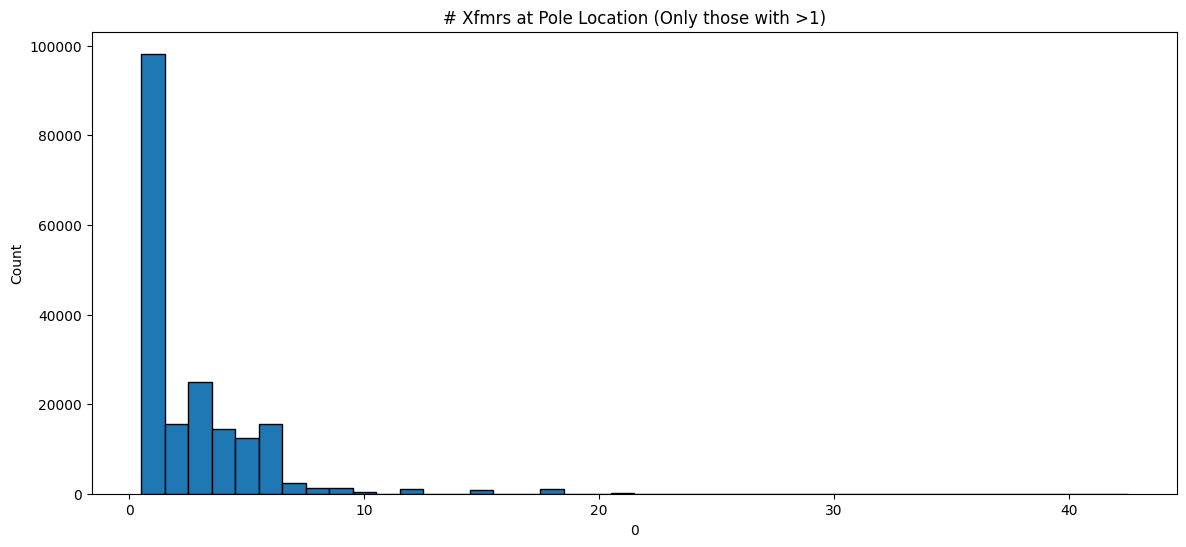

In [39]:
if merge_eemsp:
    fig,ax = Plot_General.default_subplots()
    Plot_Hist.plot_hist(
        ax=ax, 
        df=df_eemsp_reduce1.groupby('LOCATION_NB').size().to_frame(), 
        x_col=0, 
        min_max_and_bin_size=(0,10,1), 
        plot_sns=True, 
        hist_plot_kwargs=dict(discrete=True)
    )
    ax.set_title('# Xfmrs at Pole Location (Only those with >1)')

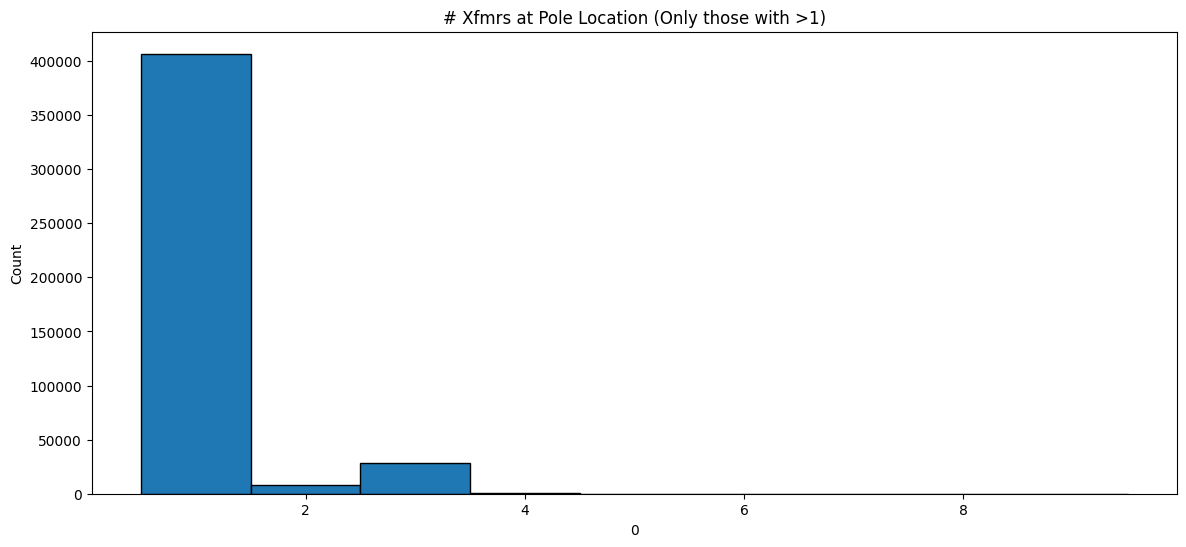

In [40]:
if merge_eemsp:
    fig,ax = Plot_General.default_subplots()
    Plot_Hist.plot_hist(
        ax=ax, 
        df=df_eemsp_reduce1.groupby(['LOCATION_NB', 'OUTG_REC_NB_TO_MERGE']).size().to_frame(), 
        x_col=0, 
        min_max_and_bin_size=(0,10,1), 
        plot_sns=True, 
        hist_plot_kwargs=dict(discrete=True)
    )
    ax.set_title('# Xfmrs at Pole Location (Only those with >1)')

In [41]:
if merge_eemsp:
    del df_eemsp_OG
    del df_eemsp_full
    del df_eemsp_reduce1
    del df_eemsp_reduce2

# TODO: Make more concrete methods for transforming install_dt

In [42]:
merged_df_full = pd.merge(
    merged_df_full, 
    Utilities_df.prepend_level_to_MultiIndex(
        df=time_infos_df,
        level_val='time_info',
        level_name=None,
        axis=1
    ), 
    left_index=True, 
    right_index=True, 
    how='left'
)
assert(merged_df_full['time_info'].isna().sum().sum()==0)
merged_df_full[('EEMSP_0', 'INSTALL_DT')] = (merged_df_full[('time_info', 't_min')] - merged_df_full[('EEMSP_0', 'INSTALL_DT')]).dt.total_seconds()/(60*60*24*365)
merged_df_full = merged_df_full.drop(columns=['time_info'])
#-------------------------
merged_df_no_outg.index.names = ['outg_rec_nb', 'trsf_pole_nb']
merged_df_no_outg = pd.merge(
    merged_df_no_outg, 
    Utilities_df.prepend_level_to_MultiIndex(
        df=time_infos_df,
        level_val='time_info',
        level_name=None,
        axis=1
    ), 
    left_index=True, 
    right_index=True, 
    how='left'
)
merged_df_no_outg.index.names = ['no_outg_rec_nb', 'trsf_pole_nb']
assert(merged_df_no_outg['time_info'].isna().sum().sum()==0)
merged_df_no_outg[('EEMSP_0', 'INSTALL_DT')] = (merged_df_no_outg[('time_info', 't_min')] - merged_df_no_outg[('EEMSP_0', 'INSTALL_DT')]).dt.total_seconds()/(60*60*24*365)
merged_df_no_outg = merged_df_no_outg.drop(columns=['time_info'])
#-------------------------
merged_df_no_outg_prstn.index.names = ['outg_rec_nb', 'trsf_pole_nb']
merged_df_no_outg_prstn = pd.merge(
    merged_df_no_outg_prstn, 
    Utilities_df.prepend_level_to_MultiIndex(
        df=time_infos_df,
        level_val='time_info',
        level_name=None,
        axis=1
    ), 
    left_index=True, 
    right_index=True, 
    how='left'
)
merged_df_no_outg_prstn.index.names = ['no_outg_rec_nb', 'trsf_pole_nb']
assert(merged_df_no_outg_prstn['time_info'].isna().sum().sum()==0)
merged_df_no_outg_prstn[('EEMSP_0', 'INSTALL_DT')] = (merged_df_no_outg_prstn[('time_info', 't_min')] - merged_df_no_outg_prstn[('EEMSP_0', 'INSTALL_DT')]).dt.total_seconds()/(60*60*24*365)
merged_df_no_outg_prstn = merged_df_no_outg_prstn.drop(columns=['time_info'])

C:\Temp\ipykernel_103760\2034662711.py:15: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  merged_df_full = merged_df_full.drop(columns=['time_info'])
C:\Temp\ipykernel_103760\2034662711.py:33: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  merged_df_no_outg = merged_df_no_outg.drop(columns=['time_info'])
C:\Temp\ipykernel_103760\2034662711.py:51: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  merged_df_no_outg_prstn = merged_df_no_outg_prstn.drop(columns=['time_info'])


In [43]:
# REMOVING SCHEDULED OUTAGES

print(f'merged_df_full.shape = {merged_df_full.shape}')

merged_df_full =  MECPODf.get_cpo_df_subset_excluding_mjr_mnr_causes( 
    cpo_df=merged_df_full, 
    mjr_mnr_causes_to_exclude=None, 
    mjr_causes_to_exclude=None,
    mnr_causes_to_exclude=['SCO', 'SO'], 
    outg_rec_nb_col='index'
)

print(f'merged_df_full.shape = {merged_df_full.shape}')

merged_df_full.shape = (122830, 89)
n_coll = 11271
batch_size = 1000
n_batches = 12


C:\Users\s346557\Documents\Analysis\GenAn.py:656: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn_db, **read_sql_args)
C:\Users\s346557\Documents\Analysis\GenAn.py:656: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn_db, **read_sql_args)
C:\Users\s346557\Documents\Analysis\GenAn.py:656: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn_db, **read_sql_args)
C:\Users\s346557\Documents\Analysis\GenAn.py:656: UserWarning: pandas only supp

10/12


C:\Users\s346557\Documents\Analysis\GenAn.py:656: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn_db, **read_sql_args)
C:\Users\s346557\Documents\Analysis\GenAn.py:656: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn_db, **read_sql_args)
C:\Users\s346557\Documents\Analysis\GenAn.py:656: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn_db, **read_sql_args)


merged_df_full.shape = (115613, 89)


In [44]:
merged_df_full.index.get_level_values(0).nunique()

8639

In [45]:
merged_df_full

01-06 Days                   \
                           Detected end of voltage sag Primary Power Up   
outg_rec_nb trsf_pole_nb                                                  
13273510    1831084763656                          0.0         0.000000   
            1831245763849                          0.0         0.000000   
            1831518763833                          0.0         0.000000   
            1831636763610                          0.0         0.000000   
            1831836763811                          0.0         0.000000   
...                                                ...              ...   
13619993    40810142B20140                         0.0         0.000000   
            40810142B20141                         0.0         0.000000   
13620003    1834970727470                          0.0         0.000000   
13620088    39831149B10124                         0.0         0.166667   
13620131    41830805C30067                         0.0         0.000000   

                                               \
                           Primary Power Down   
outg_rec_nb trsf_pole_nb                        
13273510    1831084763656            0.000000   
            1831245763849            0.000000   
            1831518763833            0.000000   
            1831636763610            0.000000   
            1831836763811            0.000000   
...                                       ...   
13619993    40810142B20140           0.000000   
            40810142B20141           0.000000   
13620003    1834970727470            0.000000   
13620088    39831149B10124           0.166667   
13620131    41830805C30067           0.000000   

                                                                  \
                           NET_MGMT command failed consecutively   
outg_rec_nb trsf_pole_nb                                           
13273510    1831084763656                               0.000000   
            1831245763849                               0.083333   
            1831518763833                               0.000000   
            1831636763610                               0.000000   
            1831836763811                               0.000000   
...                                                          ...   
13619993    40810142B20140                              0.000000   
            40810142B20141                              0.000000   
13620003    1834970727470                               0.000000   
13620088    39831149B10124                              0.000000   
13620131    41830805C30067                              0.000000   

                                                                                                        \
                           Error occurred when attempting to synch meter time with NIC time for device   
outg_rec_nb trsf_pole_nb                                                                                 
13273510    1831084763656                                                 0.0                            
            1831245763849                                                 0.0                            
            1831518763833                                                 0.0                            
            1831636763610                                                 0.0                            
            1831836763811                                                 0.0                            
...                                                                       ...                            
13619993    40810142B20140                                                0.0                            
            40810142B20141                                                0.0                            
13620003    1834970727470                                                 0.0                            
13620088    39831149B10124                                                0.0    

# Add month info

In [46]:
if include_month:
    merged_df_full_wd = DOVSOutages.append_outg_dt_off_ts_full_to_df(
        df=merged_df_full.copy(), 
        outg_rec_nb_idfr=('index', 'outg_rec_nb'), 
        dummy_col_levels_prefix='dummy_lvl_'
    )
    #-------------------------
    merged_df_no_outg_wd = merge_cpx_df_w_time_infos(
        cpx_df=merged_df_no_outg.copy(), 
        time_infos_df=no_outg_time_infos_df, 
        time_infos_drop_dupls_subset=['index', 't_min']
    )
    #-----
    merged_df_no_outg_prstn_wd = merge_cpx_df_w_time_infos(
        cpx_df=merged_df_no_outg_prstn.copy(), 
        time_infos_df=no_outg_time_infos_prstn_df, 
        time_infos_drop_dupls_subset=['index', 't_min']
    )
    #-------------------------
    if ('is_outg', 'is_outg') in merged_df_full_wd.columns:
        merged_df_full_wd = Utilities_df.move_cols_to_back(merged_df_full_wd, [('is_outg', 'is_outg')])
    if ('is_outg', 'is_outg') in merged_df_no_outg_wd.columns:
        merged_df_no_outg_wd = Utilities_df.move_cols_to_back(merged_df_no_outg_wd, [('is_outg', 'is_outg')])
    if ('is_outg', 'is_outg') in merged_df_no_outg_prstn_wd.columns:
        merged_df_no_outg_prstn_wd = Utilities_df.move_cols_to_back(merged_df_no_outg_prstn_wd, [('is_outg', 'is_outg')])
    #-------------------------
    # Change outage time to just month of outage
    merged_df_full_wd[('dummy_lvl_0', 'outg_month')] = merged_df_full_wd[('dummy_lvl_0', 'DT_OFF_TS_FULL')].dt.month

    merged_df_no_outg_wd[('dummy_lvl_0', 'outg_month')] = merged_df_no_outg_wd[('dummy_lvl_0', 't_min')].dt.month
    merged_df_no_outg_prstn_wd[('dummy_lvl_0', 'outg_month')] = merged_df_no_outg_prstn_wd[('dummy_lvl_0', 't_min')].dt.month

    #-------------------------
    merged_df_full_wd = merged_df_full_wd.drop(columns=[('dummy_lvl_0', 'DT_OFF_TS_FULL')])
    merged_df_no_outg_wd = merged_df_no_outg_wd.drop(columns=[('dummy_lvl_0', 't_min'), ('dummy_lvl_0', 't_max'), ('dummy_lvl_0', 'prem_nbs')])
    merged_df_no_outg_prstn_wd = merged_df_no_outg_prstn_wd.drop(columns=[('dummy_lvl_0', 't_min'), ('dummy_lvl_0', 't_max'), ('dummy_lvl_0', 'prem_nbs')])
    #-------------------------
    merged_df_full=merged_df_full_wd.copy()
    merged_df_no_outg=merged_df_no_outg_wd.copy()
    merged_df_no_outg_prstn=merged_df_no_outg_prstn_wd.copy()

C:\Users\s346557\Documents\Analysis\GenAn.py:656: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn_db, **read_sql_args)
C:\Users\s346557\Documents\Analysis\GenAn.py:656: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn_db, **read_sql_args)
C:\Users\s346557\Documents\Analysis\GenAn.py:656: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn_db, **read_sql_args)
C:\Users\s346557\Documents\Analysis\GenAn.py:656: UserWarning: pandas only supp

# !~!~!~!~!~!~!~!~!~!~!~!~!~!~!~!~!~!~!~!~!~!~!~!~!~!~!~

In [47]:
# Remove NETWORK and PRIMARY trsf_pole_nbs
# merged_df_no_outg=merged_df_no_outg.loc[~merged_df_no_outg.index.get_level_values(0).isin(['NETWORK', 'PRIMARY'])]
# merged_df_no_outg_prstn=merged_df_no_outg_prstn.loc[~merged_df_no_outg_prstn.index.get_level_values(0).isin(['NETWORK', 'PRIMARY'])]
merged_df_no_outg=merged_df_no_outg.loc[~merged_df_no_outg.index.get_level_values(1).isin(['NETWORK', 'PRIMARY'])]
merged_df_no_outg_prstn=merged_df_no_outg_prstn.loc[~merged_df_no_outg_prstn.index.get_level_values(1).isin(['NETWORK', 'PRIMARY'])]
#-----
merged_df_full=merged_df_full[~merged_df_full.index.get_level_values(1).isin(['NETWORK', 'PRIMARY'])]

In [48]:
# Get DOVS info to be used for setting target values
merged_df_full_w_DOVS = DOVSOutages.append_outg_info_to_df(
    df=merged_df_full.copy(), 
    outg_rec_nb_idfr=('index', 'outg_rec_nb'), 
    build_sql_function=DOVSOutages_SQL.build_sql_std_outage, 
)
merged_df_full_w_DOVS=merged_df_full_w_DOVS[['outg_dummy_lvl_0']]
merged_df_full_w_DOVS[('is_outg', 'is_outg')]=0

C:\Users\s346557\Documents\Analysis\GenAn.py:656: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn_db, **read_sql_args)
C:\Users\s346557\Documents\Analysis\GenAn.py:656: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn_db, **read_sql_args)
C:\Users\s346557\Documents\Analysis\GenAn.py:656: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn_db, **read_sql_args)
C:\Users\s346557\Documents\Analysis\GenAn.py:656: UserWarning: pandas only supp

In [49]:
# Add 'from_outg' information so I can track how many are in target=1 and target=0 
merged_df_full[('from_outg', 'from_outg')]          = 1
merged_df_no_outg[('from_outg', 'from_outg')]       = 0
merged_df_no_outg_prstn[('from_outg', 'from_outg')] = 0

In [50]:
an_keys

['01-06 Days',
 '06-11 Days',
 '11-16 Days',
 '16-21 Days',
 '21-26 Days',
 '26-31 Days']

# Drop any time periods

In [51]:
if an_keys_to_drop is not None:
    merged_df_full          = merged_df_full.drop(columns=an_keys_to_drop, level=0)
    merged_df_no_outg       = merged_df_no_outg.drop(columns=an_keys_to_drop, level=0)
    merged_df_no_outg_prstn = merged_df_no_outg_prstn.drop(columns=an_keys_to_drop, level=0)

# BEG DEV

In [52]:
# assert(0)

In [53]:
# trsf_pole_df_full = pd.read_pickle(r'C:\Users\s346557\Documents\LocalData\dovs_and_end_events_data\20231201\20230401_20230930\Outgs_Full\trsf_location_info_df.pkl')

In [54]:
# trsf_pole_df_full['city'].nunique()

In [55]:
# merged_df_full

### IDEA: Build list of slicers to do my bidding
Can create a container which holds the model results and the slicer used

### IMPORTANT! Remember transformer locations, as currently defined, can span multiple cuts, e.g., can span multiple cities

In [56]:
random_state = 42

In [57]:
if get_train_test_by_date:
    merged_df_full_train_OLD = get_cpx_outg_df_subset_by_outg_datetime(
        cpx_outg_df=merged_df_full.copy(), 
        date_0 = date_0_train,
        date_1 = date_1_train, 
        outg_rec_nb_idfr='index', 
        return_notin_also=False
    )
    merged_df_full_test_OLD = get_cpx_outg_df_subset_by_outg_datetime(
        cpx_outg_df=merged_df_full.copy(), 
        date_0 = date_0_test,
        date_1 = date_1_test, 
        outg_rec_nb_idfr='index', 
        return_notin_also=False
    )
else:
    merged_df_full_train_test = get_cpx_outg_df_subset_by_outg_datetime(
        cpx_outg_df=merged_df_full.copy(), 
        date_0 = date_0_train,
        date_1 = date_1_test, 
        outg_rec_nb_idfr='index', 
        return_notin_also=False
    )
    #-----
    if split_train_test_by_outg:
        merged_df_full_train_OLD, merged_df_full_test_OLD = train_test_split_df_by_outage(
            df=merged_df_full_train_test, 
            outg_rec_nb_idfr=('index', 'outg_rec_nb'), 
            test_size=test_size, 
            random_state=random_state
        )
    else:
        merged_df_full_train_OLD, merged_df_full_test_OLD = train_test_split(
            merged_df_full_train_test, 
            test_size=test_size, 
            random_state=random_state
        )
#-------------------------    
merged_df_full_HOLDOUT_OLD = get_cpx_outg_df_subset_by_outg_datetime(
    cpx_outg_df=merged_df_full.copy(), 
    date_0 = date_0_HOLDOUT,
    date_1 = date_1_HOLDOUT, 
    outg_rec_nb_idfr='index', 
    return_notin_also=False
)

C:\Users\s346557\Documents\Analysis\GenAn.py:656: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn_db, **read_sql_args)
C:\Users\s346557\Documents\Analysis\GenAn.py:656: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn_db, **read_sql_args)
C:\Users\s346557\Documents\Analysis\GenAn.py:656: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn_db, **read_sql_args)
C:\Users\s346557\Documents\Analysis\GenAn.py:656: UserWarning: pandas only supp

In [58]:
if get_train_test_by_date:
    merged_df_no_outg_train_OLD = get_cpx_baseline_df_subset_by_datetime(
        cpx_bsln_df = merged_df_no_outg.copy(), 
        bsln_time_infos_df = no_outg_time_infos_df.copy(), 
        date_0 = date_0_train,
        date_1 = date_1_train, 
        bsln_time_infos_time_col='t_min', 
        return_notin_also=False, 
        merge_time_info_to_cpx_bsln_df=False
    )
    merged_df_no_outg_test_OLD = get_cpx_baseline_df_subset_by_datetime(
        cpx_bsln_df = merged_df_no_outg.copy(), 
        bsln_time_infos_df = no_outg_time_infos_df.copy(), 
        date_0 = date_0_test,
        date_1 = date_1_test, 
        bsln_time_infos_time_col='t_min', 
        return_notin_also=False, 
        merge_time_info_to_cpx_bsln_df=False
    )
else:
    merged_df_no_outg_train_test = get_cpx_baseline_df_subset_by_datetime(
        cpx_bsln_df = merged_df_no_outg.copy(), 
        bsln_time_infos_df = no_outg_time_infos_df.copy(), 
        date_0 = date_0_train,
        date_1 = date_1_test, 
        bsln_time_infos_time_col='t_min', 
        return_notin_also=False, 
        merge_time_info_to_cpx_bsln_df=False
    )
    #-----
    if split_train_test_by_outg:
        merged_df_no_outg_train_OLD, merged_df_no_outg_test_OLD = train_test_split_df_by_outage(
            df=merged_df_no_outg_train_test, 
            outg_rec_nb_idfr=('index', 'no_outg_rec_nb'), 
            test_size=test_size, 
            random_state=random_state
        )
    else:
        merged_df_no_outg_train_OLD, merged_df_no_outg_test_OLD = train_test_split(
            merged_df_no_outg_train_test, 
            test_size=test_size, 
            random_state=random_state
        )
#-------------------------   
merged_df_no_outg_HOLDOUT_OLD = get_cpx_baseline_df_subset_by_datetime(
    cpx_bsln_df = merged_df_no_outg.copy(), 
    bsln_time_infos_df = no_outg_time_infos_df.copy(), 
    date_0 = date_0_HOLDOUT,
    date_1 = date_1_HOLDOUT, 
    bsln_time_infos_time_col='t_min', 
    return_notin_also=False, 
    merge_time_info_to_cpx_bsln_df=False
)
#--------------------------------------------------   
if get_train_test_by_date:
    merged_df_no_outg_prstn_train_OLD = get_cpx_baseline_df_subset_by_datetime(
        cpx_bsln_df = merged_df_no_outg_prstn.copy(), 
        bsln_time_infos_df = no_outg_time_infos_prstn_df.copy(), 
        date_0 = date_0_train,
        date_1 = date_1_train, 
        bsln_time_infos_time_col='t_min', 
        return_notin_also=False, 
        merge_time_info_to_cpx_bsln_df=False
    )
    merged_df_no_outg_prstn_test_OLD = get_cpx_baseline_df_subset_by_datetime(
        cpx_bsln_df = merged_df_no_outg_prstn.copy(), 
        bsln_time_infos_df = no_outg_time_infos_prstn_df.copy(), 
        date_0 = date_0_test,
        date_1 = date_1_test, 
        bsln_time_infos_time_col='t_min', 
        return_notin_also=False, 
        merge_time_info_to_cpx_bsln_df=False
    )
else:
    merged_df_no_outg_prstn_train_test = get_cpx_baseline_df_subset_by_datetime(
        cpx_bsln_df = merged_df_no_outg_prstn.copy(), 
        bsln_time_infos_df = no_outg_time_infos_prstn_df.copy(), 
        date_0 = date_0_train,
        date_1 = date_1_test, 
        bsln_time_infos_time_col='t_min', 
        return_notin_also=False, 
        merge_time_info_to_cpx_bsln_df=False
    )
    if split_train_test_by_outg:
        merged_df_no_outg_prstn_train_OLD, merged_df_no_outg_prstn_test_OLD = train_test_split_df_by_outage(
            df=merged_df_no_outg_prstn_train_test, 
            outg_rec_nb_idfr=('index', 'no_outg_rec_nb'), 
            test_size=test_size, 
            random_state=random_state
        )
    else:
        merged_df_no_outg_prstn_train_OLD, merged_df_no_outg_prstn_test_OLD = train_test_split(
            merged_df_no_outg_prstn_train_test, 
            test_size=test_size, 
            random_state=random_state
        )
#-------------------------   
merged_df_no_outg_prstn_HOLDOUT_OLD = get_cpx_baseline_df_subset_by_datetime(
    cpx_bsln_df = merged_df_no_outg_prstn.copy(), 
    bsln_time_infos_df = no_outg_time_infos_prstn_df.copy(), 
    date_0 = date_0_HOLDOUT,
    date_1 = date_1_HOLDOUT, 
    bsln_time_infos_time_col='t_min', 
    return_notin_also=False, 
    merge_time_info_to_cpx_bsln_df=False
)

In [59]:
split_data_dict_outg = OutageModeler.train_test_split_outg(
    df                       = merged_df_full, 
    split_train_test_by_outg = split_train_test_by_outg, 
    test_size                = test_size, 
    random_state             = random_state, 
    get_train_test_by_date   = get_train_test_by_date,
    date_range_train         = [date_0_train, date_1_train], 
    date_range_test          = [date_0_test,  date_1_test], 
    outg_rec_nb_idfr         = ('index', 'outg_rec_nb'), 
    date_range_holdout       = None, 
    verbose                  = True
)

C:\Users\s346557\Documents\Analysis\GenAn.py:656: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn_db, **read_sql_args)
C:\Users\s346557\Documents\Analysis\GenAn.py:656: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn_db, **read_sql_args)
C:\Users\s346557\Documents\Analysis\GenAn.py:656: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn_db, **read_sql_args)
C:\Users\s346557\Documents\Analysis\GenAn.py:656: UserWarning: pandas only supp

In [60]:
split_data_dict_no_outg = OutageModeler.train_test_split_bsln(
    df                       = merged_df_no_outg, 
    split_train_test_by_outg = split_train_test_by_outg, 
    test_size                = test_size, 
    random_state             = random_state, 
    get_train_test_by_date   = get_train_test_by_date,
    bsln_time_infos_df       = no_outg_time_infos_df, 
    date_range_train         = [date_0_train, date_1_train], 
    date_range_test          = [date_0_test,  date_1_test], 
    no_outg_rec_nb_idfr      = ('index', 'no_outg_rec_nb'), 
    bsln_time_infos_time_col = 't_min', 
    date_range_holdout       = None, 
    verbose                  = True
)

In [61]:
split_data_dict_no_outg_prstn = OutageModeler.train_test_split_bsln(
    df                       = merged_df_no_outg_prstn, 
    split_train_test_by_outg = split_train_test_by_outg, 
    test_size                = test_size, 
    random_state             = random_state, 
    get_train_test_by_date   = get_train_test_by_date,
    bsln_time_infos_df       = no_outg_time_infos_prstn_df, 
    date_range_train         = [date_0_train, date_1_train], 
    date_range_test          = [date_0_test,  date_1_test], 
    no_outg_rec_nb_idfr      = ('index', 'no_outg_rec_nb'), 
    bsln_time_infos_time_col = 't_min', 
    date_range_holdout       = None, 
    verbose                  = True
)

In [62]:
split_data_dict_outg.keys()

dict_keys(['train', 'test', 'holdout'])

In [63]:
print(split_data_dict_outg['train'].equals(merged_df_full_train_OLD))
print(split_data_dict_outg['test'].equals(merged_df_full_test_OLD))

True
True


In [64]:
print(split_data_dict_no_outg['train'].equals(merged_df_no_outg_train_OLD))
print(split_data_dict_no_outg['test'].equals(merged_df_no_outg_test_OLD))

True
True


In [65]:
print(split_data_dict_no_outg_prstn['train'].equals(merged_df_no_outg_prstn_train_OLD))
print(split_data_dict_no_outg_prstn['test'].equals(merged_df_no_outg_prstn_test_OLD))

True
True


In [66]:
assert(0)

AssertionError: 

# END DEV

In [ ]:
addtnl_baseline_train = pd.concat([merged_df_no_outg_train, merged_df_no_outg_prstn_train])
# addtnl_baseline_train = addtnl_baseline_train.sample(frac=0.10)

addtnl_baseline_test = pd.concat([merged_df_no_outg_test, merged_df_no_outg_prstn_test])
# addtnl_baseline_test = addtnl_baseline_test.sample(frac=0.10)

addtnl_baseline_HOLDOUT = pd.concat([merged_df_no_outg_HOLDOUT, merged_df_no_outg_prstn_HOLDOUT])
# addtnl_baseline_HOLDOUT = addtnl_baseline_HOLDOUT.sample(frac=0.10)

In [ ]:
full_data_df_train   = pd.concat([merged_df_full_train, addtnl_baseline_train])
full_data_df_test    = pd.concat([merged_df_full_test, addtnl_baseline_test])
full_data_df_HOLDOUT = pd.concat([merged_df_full_HOLDOUT, addtnl_baseline_HOLDOUT])

#Shuffle the data
full_data_df_train   = full_data_df_train.sample(frac=1)
full_data_df_test    = full_data_df_test.sample(frac=1)
full_data_df_HOLDOUT = full_data_df_HOLDOUT.sample(frac=1)

full_data_df = pd.concat([full_data_df_train, full_data_df_test, full_data_df_HOLDOUT])

# =========================================================
# =========================================================

# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [ ]:
if merge_eemsp:
    cols_to_encode = full_data_df['EEMSP_0'].columns
    numeric_cols = ['KVA_SIZE', 'INSTALL_DT']
    cols_to_encode = [('EEMSP_0', x) for x in cols_to_encode if x not in numeric_cols]
    #-------------------------
    full_data_df[cols_to_encode]         = full_data_df[cols_to_encode].astype(str)
    full_data_df_train[cols_to_encode]   = full_data_df_train[cols_to_encode].astype(str)
    full_data_df_test[cols_to_encode]    = full_data_df_test[cols_to_encode].astype(str)
    full_data_df_HOLDOUT[cols_to_encode] = full_data_df_HOLDOUT[cols_to_encode].astype(str)
    #-------------------------
    eemsp_enc = preprocessing.OrdinalEncoder(
        handle_unknown='use_encoded_value', 
        unknown_value=-1
    )
    # NOTE: In order for eemsp_enc to include the feature_names_in_ attribute (which I would like to use
    #         in model deployment to ensure the EEMSP data form matches that expected by eemsp_end), the
    #         feature names must be string.
    #       Hence the need for .droplevel(0, axis=1) below (the use within the transform call is not strictly
    #         needed, but prevents a warning message from being output)
    eemsp_enc.fit(full_data_df[cols_to_encode].droplevel(0, axis=1))
    #-----
    full_data_df_train[cols_to_encode]   = eemsp_enc.transform(full_data_df_train[cols_to_encode].droplevel(0, axis=1))
    full_data_df_test[cols_to_encode]    = eemsp_enc.transform(full_data_df_test[cols_to_encode].droplevel(0, axis=1))
    full_data_df_HOLDOUT[cols_to_encode] = eemsp_enc.transform(full_data_df_HOLDOUT[cols_to_encode].droplevel(0, axis=1))
    #-------------------------
    if save_model:
        joblib.dump(eemsp_enc, os.path.join(save_dir_model, 'eemsp_encoder.joblib'))

In [ ]:
# # if merge_eemsp:
# #     full_data_df         = full_data_df.drop(columns=[('key_0', '')])
# #     full_data_df_train   = full_data_df_train.drop(columns=[('key_0', '')])
# #     full_data_df_test    = full_data_df_test.drop(columns=[('key_0', '')])
# #     full_data_df_HOLDOUT = full_data_df_HOLDOUT.drop(columns=[('key_0', '')])
    
# #     le = preprocessing.LabelEncoder()
# #     cols_to_encode = full_data_df['EEMSP'].columns
# #     for col in cols_to_encode:
# #         le.fit(full_data_df[('EEMSP', col)])
# #         #-----
# #         full_data_df_train[('EEMSP', col)]   = le.transform(full_data_df_train[('EEMSP', col)])
# #         full_data_df_test[('EEMSP', col)]    = le.transform(full_data_df_test[('EEMSP', col)])
# #         full_data_df_HOLDOUT[('EEMSP', col)] = le.transform(full_data_df_HOLDOUT[('EEMSP', col)])

# if merge_eemsp:
#     eemsp_label_encoders = dict()
#     cols_to_encode = full_data_df['EEMSP_0'].columns
#     numeric_cols = ['KVA_SIZE', 'INSTALL_DT']
#     cols_to_encode = [x for x in cols_to_encode if x not in numeric_cols]
#     for col in cols_to_encode:
#         le = preprocessing.LabelEncoder()
#         #-----
#         full_data_df[('EEMSP_0', col)]         = full_data_df[('EEMSP_0', col)].astype(str)
#         full_data_df_train[('EEMSP_0', col)]   = full_data_df_train[('EEMSP_0', col)].astype(str)
#         full_data_df_test[('EEMSP_0', col)]    = full_data_df_test[('EEMSP_0', col)].astype(str)
#         full_data_df_HOLDOUT[('EEMSP_0', col)] = full_data_df_HOLDOUT[('EEMSP_0', col)].astype(str)
#         #-----
#         le.fit(full_data_df[('EEMSP_0', col)])
#         #-----
#         full_data_df_train[('EEMSP_0', col)]   = le.transform(full_data_df_train[('EEMSP_0', col)])
#         full_data_df_test[('EEMSP_0', col)]    = le.transform(full_data_df_test[('EEMSP_0', col)])
#         full_data_df_HOLDOUT[('EEMSP_0', col)] = le.transform(full_data_df_HOLDOUT[('EEMSP_0', col)])
#         #-----
#         assert(col not in eemsp_label_encoders.keys())
#         eemsp_label_encoders[col] = le
        
#     if save_model:
#         with open(os.path.join(save_dir_model, 'eemsp_label_encoders.pkl'), 'wb') as handle:
#             pickle.dump(eemsp_label_encoders, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Set target values

In [ ]:
# fig_save_dir_base = r'C:\Users\s346557\Documents\AnalysisNote\X_Results\X_2_OutageMeterEvents\Figures\ConfusionMatrices'
# # fig_save_subdir = 'Target_eq_1_ALL_w_EEMSP'
# fig_save_subdir = 'Target_eq_1_ALL'
# # fig_save_subdir = 'trsf_nb_eq_LocID_w_EEMSP'
# fig_save_dir = os.path.join(fig_save_dir_base, fig_save_subdir)

In [ ]:
merged_df_full_w_DOVS

In [ ]:
outg_n_xfmrs = get_n_trsf_poles_per_outg(
    df=merged_df_full, 
    outg_rec_nb_idfr='index_0', 
    trsf_pole_nb_idfr='index_1'
)
outgs_w_single_xfmr = outg_n_xfmrs[outg_n_xfmrs==1].index.tolist()
#-------------------------

In [ ]:
merged_df_full_w_DOVS_i = slicer.set_simple_column_value(df=merged_df_full_w_DOVS.copy(), column=('is_outg', 'is_outg'), value=1)
full_outg_idxs_i = merged_df_full_w_DOVS_i[merged_df_full_w_DOVS_i[('is_outg', 'is_outg')]==1].index

#NOTE: To achieve exclusion equal to that in set_target_val_1_by_idx, one could use:
#        full_outg_idxs_exclude_i = merged_df_full_w_DOVS_i[merged_df_full_w_DOVS_i[('is_outg', 'is_outg')]==0].index
#      then use .drop(index=list(set(full_data_df_i.index).intersection(set(full_outg_idxs_exclude_i))))
#      However, as noted in the function, the methods in set_target_val_1_by_idx are probably safer/more robust

In [ ]:
#-------------------------
full_data_df_i         = full_data_df.copy()
full_data_df_train_i   = full_data_df_train.copy()
full_data_df_test_i    = full_data_df_test.copy()
full_data_df_HOLDOUT_i = full_data_df_HOLDOUT.copy()
#-------------------------
full_data_df_i = set_target_val_1_by_idx(
    df=full_data_df_i,
    val_1_idxs=full_outg_idxs_i,
    remove_others_from_outages=remove_others_from_outages, 
    target_col=('is_outg', 'is_outg'), 
    from_outg_col=('from_outg', 'from_outg')
)
#-----
full_data_df_train_i = set_target_val_1_by_idx(
    df=full_data_df_train_i,
    val_1_idxs=full_outg_idxs_i,
    remove_others_from_outages=remove_others_from_outages, 
    target_col=('is_outg', 'is_outg'), 
    from_outg_col=('from_outg', 'from_outg')
)
#-----
full_data_df_test_i = set_target_val_1_by_idx(
    df=full_data_df_test_i,
    val_1_idxs=full_outg_idxs_i,
    remove_others_from_outages=remove_others_from_outages, 
    target_col=('is_outg', 'is_outg'), 
    from_outg_col=('from_outg', 'from_outg')
)
#-----
full_data_df_HOLDOUT_i = set_target_val_1_by_idx(
    df=full_data_df_HOLDOUT_i,
    val_1_idxs=full_outg_idxs_i,
    remove_others_from_outages=remove_others_from_outages, 
    target_col=('is_outg', 'is_outg'), 
    from_outg_col=('from_outg', 'from_outg')
)

In [ ]:
#--------------------------------------------------
n_outg_target_1_train = full_data_df_train_i[('is_outg', 'is_outg')].sum()
n_outg_target_0_train = full_data_df_train_i[
    (full_data_df_train_i[('from_outg', 'from_outg')]==1) & 
    (full_data_df_train_i[('is_outg', 'is_outg')]==0)
].shape[0]
n_bsln_train = full_data_df_train_i[full_data_df_train_i[('from_outg', 'from_outg')]==0].shape[0]
assert(full_data_df_train_i.shape[0]==n_outg_target_1_train+n_outg_target_0_train+n_bsln_train)
pct_target_1_train = 100*n_outg_target_1_train/(n_outg_target_1_train+n_outg_target_0_train+n_bsln_train)
#-----
print('\n----- TRAIN -----')
print(f"# direct outages (target = 1):      {n_outg_target_1_train}")
print(f"# indirect outages (target = 0):    {n_outg_target_0_train}")
print(f"\t% direct = {100*n_outg_target_1_train/(n_outg_target_1_train+n_outg_target_0_train)}")
print(f"# additional baseline (target = 0): {n_bsln_train}")
print(f"%(target==1):                       {pct_target_1_train}%")

#--------------------------------------------------
n_outg_target_1_test = full_data_df_test_i[('is_outg', 'is_outg')].sum()
n_outg_target_0_test = full_data_df_test_i[
    (full_data_df_test_i[('from_outg', 'from_outg')]==1) & 
    (full_data_df_test_i[('is_outg', 'is_outg')]==0)
].shape[0]
n_bsln_test = full_data_df_test_i[full_data_df_test_i[('from_outg', 'from_outg')]==0].shape[0]
assert(full_data_df_test_i.shape[0]==n_outg_target_1_test+n_outg_target_0_test+n_bsln_test)
pct_target_1_test = 100*n_outg_target_1_test/(n_outg_target_1_test+n_outg_target_0_test+n_bsln_test)
#-----
print('\n----- TEST -----')
print(f"# direct outages (target = 1):      {n_outg_target_1_test}")
print(f"# indirect outages (target = 0):    {n_outg_target_0_test}")
print(f"\t% direct = {100*n_outg_target_1_test/(n_outg_target_1_test+n_outg_target_0_test)}")
print(f"# additional baseline (target = 0): {n_bsln_test}")
print(f"%(target==1):                       {pct_target_1_test}%")

#--------------------------------------------------
n_outg_target_1_HOLDOUT = full_data_df_HOLDOUT_i[('is_outg', 'is_outg')].sum()
n_outg_target_0_HOLDOUT = full_data_df_HOLDOUT_i[
    (full_data_df_HOLDOUT_i[('from_outg', 'from_outg')]==1) & 
    (full_data_df_HOLDOUT_i[('is_outg', 'is_outg')]==0)
].shape[0]
n_bsln_HOLDOUT = full_data_df_HOLDOUT_i[full_data_df_HOLDOUT_i[('from_outg', 'from_outg')]==0].shape[0]
assert(full_data_df_HOLDOUT_i.shape[0]==n_outg_target_1_HOLDOUT+n_outg_target_0_HOLDOUT+n_bsln_HOLDOUT)
pct_target_1_HOLDOUT = 100*n_outg_target_1_HOLDOUT/(n_outg_target_1_HOLDOUT+n_outg_target_0_HOLDOUT+n_bsln_HOLDOUT)
#-----
print('\n----- HOLDOUT -----')
print(f"# direct outages (target = 1):      {n_outg_target_1_HOLDOUT}")
print(f"# indirect outages (target = 0):    {n_outg_target_0_HOLDOUT}")
print(f"\t% direct = {100*n_outg_target_1_HOLDOUT/(n_outg_target_1_HOLDOUT+n_outg_target_0_HOLDOUT)}")
print(f"# additional baseline (target = 0): {n_bsln_HOLDOUT}")
print(f"%(target==1):                       {pct_target_1_HOLDOUT}%")

In [ ]:
if (
    full_data_df_train_i[('is_outg', 'is_outg')].sum()==0 or 
    full_data_df_test_i[('is_outg', 'is_outg')].sum()==0 or 
    full_data_df_HOLDOUT_i[('is_outg', 'is_outg')].sum()==0
):
    print('Not enough target value==1 in train, test, and/or holdout')
    print(f"#target==1 train:   {full_data_df_train_i[('is_outg', 'is_outg')].sum()}")
    print(f"#target==1 test:    {full_data_df_test_i[('is_outg', 'is_outg')].sum()}")
    print(f"#target==1 holdout: {full_data_df_HOLDOUT_i[('is_outg', 'is_outg')].sum()}")

In [ ]:
full_data_df_train_i

In [ ]:
if min_pct_target_1 is not None:
    full_data_df_train_i = ensure_target_val_1_min_pct(
        df=full_data_df_train_i,
        min_pct=min_pct_target_1,
        target_col=('is_outg', 'is_outg'), 
        random_state=random_state, 
        return_discarded=False
    )
    #-----
    full_data_df_test_i = ensure_target_val_1_min_pct(
        df=full_data_df_test_i,
        min_pct=min_pct_target_1,
        target_col=('is_outg', 'is_outg'), 
        random_state=random_state, 
        return_discarded=False
    )
    #-----
    full_data_df_HOLDOUT_i = ensure_target_val_1_min_pct(
        df=full_data_df_HOLDOUT_i,
        min_pct=min_pct_target_1,
        target_col=('is_outg', 'is_outg'), 
        random_state=random_state, 
        return_discarded=False
    )
    #-----

In [ ]:
#--------------------------------------------------
n_outg_target_1_train = full_data_df_train_i[('is_outg', 'is_outg')].sum()
n_outg_target_0_train = full_data_df_train_i[
    (full_data_df_train_i[('from_outg', 'from_outg')]==1) & 
    (full_data_df_train_i[('is_outg', 'is_outg')]==0)
].shape[0]
n_bsln_train = full_data_df_train_i[full_data_df_train_i[('from_outg', 'from_outg')]==0].shape[0]
assert(full_data_df_train_i.shape[0]==n_outg_target_1_train+n_outg_target_0_train+n_bsln_train)
pct_target_1_train = 100*n_outg_target_1_train/(n_outg_target_1_train+n_outg_target_0_train+n_bsln_train)
#-----
print('\n----- TRAIN -----')
print(f"# direct outages (target = 1):      {n_outg_target_1_train}")
print(f"# indirect outages (target = 0):    {n_outg_target_0_train}")
print(f"\t% direct = {100*n_outg_target_1_train/(n_outg_target_1_train+n_outg_target_0_train)}")
print(f"# additional baseline (target = 0): {n_bsln_train}")
print(f"%(target==1):                       {pct_target_1_train}%")

#--------------------------------------------------
n_outg_target_1_test = full_data_df_test_i[('is_outg', 'is_outg')].sum()
n_outg_target_0_test = full_data_df_test_i[
    (full_data_df_test_i[('from_outg', 'from_outg')]==1) & 
    (full_data_df_test_i[('is_outg', 'is_outg')]==0)
].shape[0]
n_bsln_test = full_data_df_test_i[full_data_df_test_i[('from_outg', 'from_outg')]==0].shape[0]
assert(full_data_df_test_i.shape[0]==n_outg_target_1_test+n_outg_target_0_test+n_bsln_test)
pct_target_1_test = 100*n_outg_target_1_test/(n_outg_target_1_test+n_outg_target_0_test+n_bsln_test)
#-----
print('\n----- TEST -----')
print(f"# direct outages (target = 1):      {n_outg_target_1_test}")
print(f"# indirect outages (target = 0):    {n_outg_target_0_test}")
print(f"\t% direct = {100*n_outg_target_1_test/(n_outg_target_1_test+n_outg_target_0_test)}")
print(f"# additional baseline (target = 0): {n_bsln_test}")
print(f"%(target==1):                       {pct_target_1_test}%")

#--------------------------------------------------
n_outg_target_1_HOLDOUT = full_data_df_HOLDOUT_i[('is_outg', 'is_outg')].sum()
n_outg_target_0_HOLDOUT = full_data_df_HOLDOUT_i[
    (full_data_df_HOLDOUT_i[('from_outg', 'from_outg')]==1) & 
    (full_data_df_HOLDOUT_i[('is_outg', 'is_outg')]==0)
].shape[0]
n_bsln_HOLDOUT = full_data_df_HOLDOUT_i[full_data_df_HOLDOUT_i[('from_outg', 'from_outg')]==0].shape[0]
assert(full_data_df_HOLDOUT_i.shape[0]==n_outg_target_1_HOLDOUT+n_outg_target_0_HOLDOUT+n_bsln_HOLDOUT)
pct_target_1_HOLDOUT = 100*n_outg_target_1_HOLDOUT/(n_outg_target_1_HOLDOUT+n_outg_target_0_HOLDOUT+n_bsln_HOLDOUT)
#-----
print('\n----- HOLDOUT -----')
print(f"# direct outages (target = 1):      {n_outg_target_1_HOLDOUT}")
print(f"# indirect outages (target = 0):    {n_outg_target_0_HOLDOUT}")
print(f"\t% direct = {100*n_outg_target_1_HOLDOUT/(n_outg_target_1_HOLDOUT+n_outg_target_0_HOLDOUT)}")
print(f"# additional baseline (target = 0): {n_bsln_HOLDOUT}")
print(f"%(target==1):                       {pct_target_1_HOLDOUT}%")

In [ ]:
if ('from_outg', 'from_outg') in full_data_df_i.columns.tolist():
    full_data_df_i = full_data_df_i.drop(columns=[('from_outg', 'from_outg')])
if ('from_outg', 'from_outg') in full_data_df_train_i.columns.tolist():
    full_data_df_train_i = full_data_df_train_i.drop(columns=[('from_outg', 'from_outg')])
if ('from_outg', 'from_outg') in full_data_df_test_i.columns.tolist():
    full_data_df_test_i = full_data_df_test_i.drop(columns=[('from_outg', 'from_outg')])
if ('from_outg', 'from_outg') in full_data_df_HOLDOUT_i.columns.tolist():
    full_data_df_HOLDOUT_i = full_data_df_HOLDOUT_i.drop(columns=[('from_outg', 'from_outg')])

In [ ]:
if reduce_train_size:
    if split_train_test_by_outg:
        full_data_df_train_i, _ = train_test_split_df_by_outage(
            df=full_data_df_train_i, 
            outg_rec_nb_idfr='index_0', 
            test_size=red_test_size, 
            random_state=random_state
        )
    else:
        full_data_df_train_i, _ = train_test_split(
            full_data_df_train_i, 
            test_size=red_test_size, 
            random_state=random_state
        )

# Prepare Data

In [ ]:
full_data_df_train_i.isna().sum()

In [ ]:
ugh = full_data_df_train_i.isna().sum()

In [ ]:
ugh[ugh>0]

In [ ]:
print(full_data_df_train_i.shape[0])
full_data_df_train_i = full_data_df_train_i.dropna()
print(full_data_df_train_i.shape[0])
print()
#-----
print(full_data_df_test_i.shape[0])
full_data_df_test_i = full_data_df_test_i.dropna()
print(full_data_df_test_i.shape[0])
print()
#-----
print(full_data_df_HOLDOUT_i.shape[0])
full_data_df_HOLDOUT_i = full_data_df_HOLDOUT_i.dropna()
print(full_data_df_HOLDOUT_i.shape[0])
print()
#-----

In [ ]:
full_data_df_test_i

In [ ]:
full_data_df_HOLDOUT_i

In [ ]:
# full_data_df_train_i   = full_data_df_train_i.drop(columns=('dummy_lvl_0', 'outg_month'))
# full_data_df_test_i    = full_data_df_test_i.drop(columns=('dummy_lvl_0', 'outg_month'))
# full_data_df_HOLDOUT_i = full_data_df_HOLDOUT_i.drop(columns=('dummy_lvl_0', 'outg_month'))

In [ ]:
set(full_data_df_train_i.columns.tolist()).symmetric_difference(set(full_data_df.columns.tolist()))

In [ ]:
#-------------------------
X_train_OG = full_data_df_train_i.iloc[:, :-1].copy()
y_train    = full_data_df_train_i.iloc[:, -1].copy()

X_test_OG = full_data_df_test_i.iloc[:, :-1].copy()
y_test    = full_data_df_test_i.iloc[:, -1].copy()

X_HOLDOUT = full_data_df_HOLDOUT_i.iloc[:, :-1]
y_HOLDOUT = full_data_df_HOLDOUT_i.iloc[:, -1]
#-------------------------
if save_model:
    X_train_OG.head().to_pickle(os.path.join(save_dir_model, 'data_structure_df.pkl'))

In [ ]:
fig, axs = Plot_General.default_subplots(2,2, return_flattened_axes=True)
#-------------------------
sns.countplot(ax=axs[0], x = ('is_outg', 'is_outg'), data=full_data_df_i)
axs[0].set_title('Full Data');
axs[0].set_xlabel('Is Outage');
axs[0].set_ylim([1.05*x for x in axs[0].get_ylim()])
for p in axs[0].patches:
    pct = (p.get_height()/full_data_df_i.shape[0]).round(5)
    txt = f'{pct}%'
    txt_x = p.get_x() 
    txt_y = 1.025*p.get_height()
    axs[0].text(txt_x,txt_y,txt)
#-------------------------
sns.countplot(ax=axs[1], x = ('is_outg', 'is_outg'), data=y_train.to_frame())
axs[1].set_title('Training Data');
axs[1].set_xlabel('Is Outage');
axs[1].set_ylim([1.05*x for x in axs[1].get_ylim()])
for p in axs[1].patches:
    pct = (p.get_height()/y_train.shape[0]).round(5)
    txt = f'{pct}%'
    txt_x = p.get_x() 
    txt_y = 1.025*p.get_height()
    axs[1].text(txt_x,txt_y,txt)
#-------------------------
sns.countplot(ax=axs[2], x = ('is_outg', 'is_outg'), data=y_test.to_frame())
axs[2].set_title('Testing Data');
axs[2].set_xlabel('Is Outage');
axs[2].set_ylim([1.05*x for x in axs[2].get_ylim()])
for p in axs[2].patches:
    pct = (p.get_height()/y_test.shape[0]).round(5)
    txt = f'{pct}%'
    txt_x = p.get_x() 
    txt_y = 1.025*p.get_height()
    axs[2].text(txt_x,txt_y,txt)
#-------------------------
sns.countplot(ax=axs[3], x = ('is_outg', 'is_outg'), data=y_HOLDOUT.to_frame())
axs[3].set_title('Holdout Data');
axs[3].set_xlabel('Is Outage');
axs[3].set_ylim([1.05*x for x in axs[3].get_ylim()])
for p in axs[3].patches:
    pct = (p.get_height()/y_HOLDOUT.shape[0]).round(5)
    txt = f'{pct}%'
    txt_x = p.get_x() 
    txt_y = 1.025*p.get_height()
    axs[3].text(txt_x,txt_y,txt)

In [ ]:
create_validation_set

In [ ]:
run_PCA

In [ ]:
run_scaler

In [ ]:
#-------------------------
if create_validation_set:
    if split_train_test_by_outg:
        X_train_OG, X_val_OG, y_train, y_val = train_test_split_df_group(
            X=X_train_OG, 
            y=y_train, 
            groups=X_train_OG.index.get_level_values(0), 
            test_size=val_size, 
            random_state=random_state
        )
    else:
        X_train_OG, X_val_OG, y_train, y_val = train_test_split(X_train_OG, y_train, test_size=val_size, random_state=random_state)
#-------------------------
if run_scaler:
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train_OG)
    #-----
    if create_validation_set:
        X_val   = scaler.transform(X_val_OG)
    X_test  = scaler.transform(X_test_OG)
    X_HOLDOUT   = scaler.transform(X_HOLDOUT)
    #-----
    if save_model:
        joblib.dump(scaler, os.path.join(save_dir_model, 'scaler.joblib'))
else:
    X_train = X_train_OG
    if create_validation_set:
        X_val   = X_val_OG
    X_test  = X_test_OG

In [ ]:
X_train_OG

In [ ]:
X_train.shape

In [ ]:
X_train

In [ ]:
if run_PCA:
    # First, generate a PCA plot, showing the explained variance on the y-axis and number of components on x
    # This is simply to check that the number of components kept looks correct
    pca = PCA()
    pca.fit(X_train)
    cumsum = np.cumsum(pca.explained_variance_ratio_)
    plt.plot(cumsum)
    
    # Now, run the PCA with pca_n_components and perform transforms
    pca=PCA(n_components=pca_n_components)
    X_train = pca.fit_transform(X_train)
    print(f'PCA n-components       = {pca.n_components_}')
    print(f'PCA explained variance = {pca.explained_variance_ratio_.sum()}')
    #-----
    if create_validation_set:
        X_val      = pca.transform(X_val)
    X_test     = pca.transform(X_test)
    X_HOLDOUT  = pca.transform(X_HOLDOUT)

# Dumb Classifier

In [ ]:
dumb_clf = DumbClassifier()
cross_val_score(dumb_clf, X_train, y_train, cv=3, scoring='accuracy')

In [ ]:
# y_pred = dumb_clf.predict(X_test)
# print("ACCURACY  OF THE MODEL: ", accuracy_score(y_test, y_pred))
# print("PRECISION OF THE MODEL: ", precision_score(y_test, y_pred))
# print("RECALL    OF THE MODEL: ", recall_score(y_test, y_pred))

In [ ]:
# confusion_matrix(y_test, y_pred)

# Random Forest

In [ ]:
# forest_clf = RandomForestClassifier(n_estimators = 100)
# forest_clf = RandomForestClassifier(n_estimators = 1000, n_jobs=-1)
# forest_clf = RandomForestClassifier(n_estimators = 1000, criterion='entropy', n_jobs=-1)

# forest_clf = RandomForestClassifier(n_estimators = 1000, n_jobs=-1)
# forest_clf = RandomForestClassifier(n_estimators = 1000, max_depth=25, n_jobs=-1)
forest_clf = RandomForestClassifier(n_estimators = 1000, max_depth=25, n_jobs=None)
# forest_clf = RandomForestClassifier(n_estimators = 1000, max_depth=25, n_jobs=None, class_weight='balanced')
# forest_clf = RandomForestClassifier(n_estimators = 1000, max_depth=None, n_jobs=None) #probably dont want max_depth=None
# forest_clf = RandomForestClassifier(n_estimators = 5000, max_depth=50, n_jobs=None)

In [ ]:
start = time.time()
forest_clf.fit(X_train, y_train)
print(time.time()-start)

In [ ]:
# Combine mecpo_build_info_dict and summary_dict
assert(set(mecpo_build_info_dict.keys()).intersection(set(summary_dict.keys()))==set())
summary_dict = summary_dict | mecpo_build_info_dict
#-------------------------
if save_results:
    CustomWriter.output_dict_to_json(
        os.path.join(save_dir_model, 'summary_dict.json'), 
        summary_dict
    )
#-----
if save_model:
    joblib.dump(forest_clf, os.path.join(save_dir_model, 'forest_clf.joblib'))

In [ ]:
y_pred_train = forest_clf.predict(X_train)
print('*****'*5)
print('TRAINING DATASET')
print('*****'*5)
print(f"#(target==1): {y_train.sum()}")
print(f"#(target==0): {y_train.shape[0]-y_train.sum()}")
print(f"%(target==1): {100*(y_train.sum()/(y_train.shape[0]))}")
print('-----'*5)
print("ACCURACY  OF THE MODEL: ", accuracy_score(y_train, y_pred_train))
print("PRECISION OF THE MODEL: ", precision_score(y_train, y_pred_train))
print("RECALL    OF THE MODEL: ", recall_score(y_train, y_pred_train))
print()

y_pred = forest_clf.predict(X_test)
print('*****'*5)
print('TESTING DATASET')
print('*****'*5)
print(f"#(target==1): {y_test.sum()}")
print(f"#(target==0): {y_test.shape[0]-y_test.sum()}")
print(f"%(target==1): {100*(y_test.sum()/(y_test.shape[0]))}")
print('-----'*5)
print("ACCURACY  OF THE MODEL: ", accuracy_score(y_test, y_pred))
print("PRECISION OF THE MODEL: ", precision_score(y_test, y_pred))
print("RECALL    OF THE MODEL: ", recall_score(y_test, y_pred))
print()

# y_pred_HOLDOUT = forest_clf.predict(X_HOLDOUT)
# print('*****'*5)
# print('HOLDOOUT DATASET')
# print('*****'*5)
# print(f"#(target==1): {y_HOLDOUT.sum()}")
# print(f"#(target==0): {y_HOLDOUT.shape[0]-y_HOLDOUT.sum()}")
# print(f"%(target==1): {100*(y_HOLDOUT.sum()/(y_HOLDOUT.shape[0]))}")
# print('-----'*5)
# print("ACCURACY  OF THE MODEL: ", accuracy_score(y_HOLDOUT, y_pred_HOLDOUT))
# print("PRECISION OF THE MODEL: ", precision_score(y_HOLDOUT, y_pred_HOLDOUT))
# print("RECALL    OF THE MODEL: ", recall_score(y_HOLDOUT, y_pred_HOLDOUT))

In [ ]:
outg_n_xfmrs = get_n_trsf_poles_per_outg(
    df=merged_df_full, 
    outg_rec_nb_idfr='index_0', 
    trsf_pole_nb_idfr='index_1'
)
outgs_w_single_xfmr = outg_n_xfmrs[outg_n_xfmrs==1].index.tolist()
#-------------------------
n_dir_indir_tp_fn_train = get_n_direct_xfmrs_in_tp_fn(
    data_df=full_data_df_train_i, 
    y_pred=y_pred_train, 
    y_col=('is_outg', 'is_outg'), 
    outgs_w_single_xfmr=outgs_w_single_xfmr, 
    xfmr_equip_typ_nms_of_interest=None, 
    outg_rec_nb_idfr='index_0', 
    trsf_pole_nb_idfr='index_1'
)
#-----
n_dir_indir_tp_fn_test = get_n_direct_xfmrs_in_tp_fn(
    data_df=full_data_df_test_i, 
    y_pred=y_pred, 
    y_col=('is_outg', 'is_outg'), 
    outgs_w_single_xfmr=outgs_w_single_xfmr, 
    xfmr_equip_typ_nms_of_interest=None, 
    outg_rec_nb_idfr='index_0', 
    trsf_pole_nb_idfr='index_1'
)

In [ ]:
save_figs    = save_results
fig_save_dir = save_dir_model

In [ ]:
# fig, axs = Plot_General.default_subplots(
#     n_x=1, 
#     n_y=3, 
#     fig_num=fig_num, 
#     unit_figsize_width=6., 
#     unit_figsize_height=4., 
# )
# Plot_General.adjust_subplots_args(fig, dict(hspace=0.4))
# #-----
# cmd = draw_outg_confusion_matrix(
#     y=y_train, 
#     y_pred=y_pred_train, 
#     title='Train', 
#     normalize=None, 
#     scientific=True, 
#     ax=axs[0]
# )
# #-----
# cmd = draw_outg_confusion_matrix(
#     y=y_test, 
#     y_pred=y_pred, 
#     title='Test', 
#     normalize=None, 
#     scientific=True, 
#     ax=axs[1]
# )
# #-----
# cmd = draw_outg_confusion_matrix(
#     y=y_HOLDOUT, 
#     y_pred=y_pred_HOLDOUT, 
#     title='Holdout', 
#     normalize=None, 
#     scientific=True, 
#     ax=axs[2]
# )
# #-----
# if save_figs:
#     if not os.path.exists(fig_save_dir):
#         os.makedirs(fig_save_dir)
#     Plot_General.save_fig(
#         fig=fig, 
#         save_dir=fig_save_dir, 
#         save_name='ConfusionMatrices.png', 
#         bbox_inches='tight'
#     )
# #-----
# fig_num+=1

In [ ]:
fig, axs = Plot_General.default_subplots(
    n_x=1, 
    n_y=2, 
    fig_num=fig_num, 
    unit_figsize_width=6., 
    unit_figsize_height=4., 
)
Plot_General.adjust_subplots_args(fig, dict(hspace=0.4))
#-----
cmd = draw_outg_confusion_matrix(
    y=y_train, 
    y_pred=y_pred_train, 
    title='Train', 
    normalize=None, 
    scientific=False, 
    ax=axs[0], 
    n_dir_indir_tp_fn=n_dir_indir_tp_fn_train
)
#-----
cmd = draw_outg_confusion_matrix(
    y=y_test, 
    y_pred=y_pred, 
    title='Test', 
    normalize=None, 
    scientific=False, 
    ax=axs[1], 
    n_dir_indir_tp_fn=n_dir_indir_tp_fn_test
)
#-----
if save_figs:
    if not os.path.exists(fig_save_dir):
        os.makedirs(fig_save_dir)
    Plot_General.save_fig(
        fig=fig, 
        save_dir=fig_save_dir, 
        save_name='ConfusionMatrices.png', 
        bbox_inches='tight'
    )
#-----
fig_num+=1